In [1]:
import clip

print(clip.__file__)
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from multiproc_converter_to_png import convert_svgs_to_pngs_parallel, load_images_parallel
import cairosvg
from IPython.display import display
from AScore import simple_inference as asp
from tqdm.notebook import tqdm
import seaborn as sns
from datasets import Dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import kagglehub
import os
import re
from multiproc_converter_to_png import convert_svgs_to_pngs_parallel_in_memory
from transformers import DataCollatorWithPadding
from collections import Counter
from configs.config_util import *
cur_path = os.getcwd()

/home/student/kuzin/python_project/TextToSvg_MLCUP/.venv/lib/python3.10/site-packages/clip/__init__.py


/home/student/kuzin/python_project/TextToSvg_MLCUP/.venv/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/home/student/kuzin/python_project/TextToSvg_MLCUP/.venv/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


In [2]:
path_to_train_data = "./AScore/train_data/ava_y_openclip_l14.npy"

In [27]:
y = np.load (path_to_train_data)

### Статистика оценок визуальной эстетичност, на которой обучали AScore predictor

(0    6.574586
 Name: 0.95, dtype: float64,
                    0
 count  255490.000000
 mean        5.383315
 std         0.731305
 min         1.808989
 25%         4.911222
 50%         5.386667
 75%         5.865672
 max         8.600000)

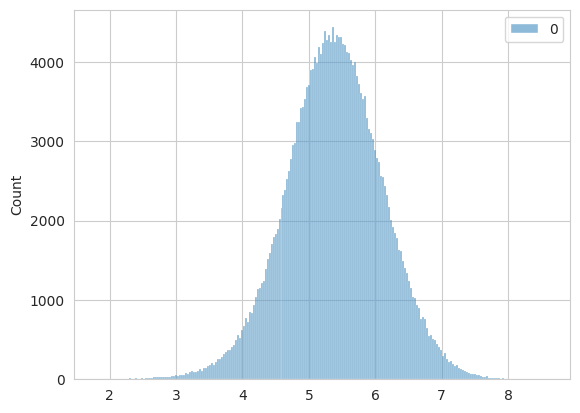

In [28]:
df = pd.DataFrame(y)
sns.histplot(df)
df.quantile(0.95), df.describe()

In [29]:
path = kagglehub.dataset_download("harrabiraouf/scored-svg-11k")
print("Path to dataset files:", path)
eval_dataset = pd.read_csv(os.path.join(path, "svg_dataset_scored_11k.csv"))

Path to dataset files: /home/student/.cache/kagglehub/datasets/harrabiraouf/scored-svg-11k/versions/1


In [30]:
eval_dataset.head(5)

,sentence,best_image_score,svg_code
0,An indigo hexagon bloom glistens with morning ...,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
1,Sharp mountain silhouettes stand amidst a grad...,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
2,A tree composed of interlocking hexagons stand...,0.9965,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
3,Lavender desert stretching endlessly under moo...,0.9975,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
4,"A gradient amber, peach, and cobalt sky over e...",0.9997,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."


In [31]:
eval_dataset.index, eval_dataset.index.nunique()

(RangeIndex(start=0, stop=11188, step=1), 11188)

#### Filter eval_dataset

In [32]:
print(len(eval_dataset))
eval_dataset = eval_dataset.dropna().reset_index(drop=True)
print(len(eval_dataset))
eval_dataset.index, eval_dataset.index.nunique()

11188
11170


(RangeIndex(start=0, stop=11170, step=1), 11170)

In [33]:
def is_renderable_svg(row, output_path="temp_output.png"):
    try:
        cairosvg.svg2png(bytestring=row['svg_code'].encode('utf-8'), write_to=output_path)
        return True
    except Exception as e:
        print("Ошибка рендеринга SVG:", e)
        return False

eval_dataset["is_valid"] = eval_dataset.apply(is_renderable_svg,axis =1)
valid_eval_dataset = eval_dataset[eval_dataset["is_valid"] == True]

In [34]:
num_processes = cpu_count()
output_folder = "./data/eval_models_png"
print(num_processes)
list(map(lambda index: os.path.join(output_folder, f"{index}.png"), [1,2,3] ))

32


['./data/eval_models_png/1.png',
 './data/eval_models_png/2.png',
 './data/eval_models_png/3.png']

#### Конвертируем в PNG и запишем в память все SVG из датасета

In [35]:
for_path_columns = []
for i in tqdm(range(0, len(eval_dataset), num_processes), 
              total=len(range(0, len(eval_dataset), num_processes)), 
              desc="Processing batches"):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["svg_code"][start_i:end_i].to_dict()
    for_path_columns+=  list(map(lambda index: os.path.join(output_folder, f"{index}.png"),np.arange(start_i,end_i) ))
    res = convert_svgs_to_pngs_parallel(batch,output_folder,num_processes)
    print(sum(list(res.values())))
    assert sum(list(res.values())) == len(batch)

Processing batches:   0%|          | 0/350 [00:00<?, ?it/s]

Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 пр

In [36]:
def collect_numbers_from_filenames(folder):
    filenames = os.listdir(folder)
    numbers = []
    for filename in filenames:
        if filename.endswith(".png"):
            try:
                number = int(filename[:-4])
                numbers.append(number)
            except ValueError:
                pass
    return sorted(numbers)
numbers_list = collect_numbers_from_filenames(output_folder)

counts = Counter(numbers_list)
duplicates = [number for number, count in counts.items() if count > 1]
print(len(numbers_list))
print("Повторяющиеся числа:", duplicates)
assert len(numbers_list) == len(eval_dataset)
assert len(duplicates) ==0
max(numbers_list)

11170
Повторяющиеся числа: []


11169

In [37]:
for_path_columns = for_path_columns[:len(eval_dataset)]
for_path_columns[-3:], len(eval_dataset)

(['./data/eval_models_png/11167.png',
  './data/eval_models_png/11168.png',
  './data/eval_models_png/11169.png'],
 11170)

#### Сохраним в PNG 

In [1]:
eval_dataset["path_to_png"] = for_path_columns
eval_dataset.to_csv("./data/svg_eval_dataset.csv")
eval_dataset.head(5)

NameError: name 'for_path_columns' is not defined

### датасет, в котором храним пути на PNG

In [3]:
eval_dataset = pd.read_csv("./data/svg_eval_dataset.csv")

### Посмотрим, какие скоры эстетичности выдаёт предиктор на датасете

Ключ: 0


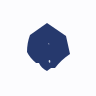

Ключ: 1


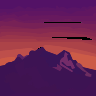

Ключ: 2


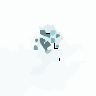

Ключ: 3


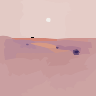

Ключ: 4


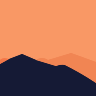

In [4]:
for_path_columns = []
num_processes = 5
for i in range(0,5,num_processes):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    images = load_images_parallel(batch, num_processes)

    for key, img in images.items():
        print(f"Ключ: {key}")
        display(img)
    

In [5]:
MLP_name = "AScore/sac+logos+ava1-l14-linearMSE.pth"
full_path= os.path.join(cur_path, MLP_name)
score_predictor = asp.AScorePredictor(full_path)
batch  = list(images.values())
res  = score_predictor.get_score(batch)
res

tensor([[3.8287],
        [4.9325],
        [3.5909],
        [4.8256],
        [4.6752]], device='cuda:0')

#### Посчитаем скор на всём датасете

In [ ]:
for_original_score_column = []
num_processes = 32
for i in tqdm(range(0, len(eval_dataset), num_processes), 
              total=len(range(0, len(eval_dataset), num_processes)), 
              desc="Processing batches"):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    images = load_images_parallel(batch, num_processes)
    batch_scores = score_predictor.get_score(list(images.values())).detach().cpu().numpy()
    for_original_score_column.append(batch_scores)
    

In [43]:
len(for_original_score_column)
res = np.vstack(for_original_score_column)
len(res)
eval_dataset["original_AScore"] = res
eval_dataset.to_csv("./data/svg_eval_dataset.csv", index=False)
eval_dataset.head(5)

,Unnamed: 0,sentence,best_image_score,svg_code,path_to_png,original_AScore
0,0,An indigo hexagon bloom glistens with morning dew.,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#fcfcfe"" d=""M0 0h96v96H0z""/><path fill=""#26396d"" d=""m47 23 19 13 4 18q-9 6-15 14h-4l-4 3q-6-3-8-8h-3q-6-5-9-11 0-9 3-17z""/><path fill=""#949db5"" d=""M48 43q2 0 1 2z""/><path fill=""#d7dde6"" d=""M49 60q2 0 1 3-2-1-1-3""/></svg>",./data/eval_models_png/0.png,3.827508
1,1,Sharp mountain silhouettes stand amidst a gradient violet to amber sky.,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#531266"" d=""M0 0h96v6l-3 1q-3-2-6 1-4-3-6 1-7-3-14 0-4-3-8-1-3-5-3 1-10-3-21 0l-7-2-3 2-6-3-6 3H0z""/><path fill=""#5a1564"" d=""m93 7-6 3q-2-2-2 0l1 1h-9l-6 3-9-3H28q-11 0-21 3l-1-2-6 1V9h13l6-3 6 3 3-2 7 2q11-3 21 0 0-6 3-1 4-2 8 1 7-3 14 0 2-4 6-1 3-3 6-1""/><path fill=""#601661"" d=""M96 6v7q-3 0-3 3-3-2-6 1L0 16v-3l6-1 1 2q10-3 21-3h34l9 3 6-3h9l-1-1q0-2 2 0l6-3z""/><path fill=""#67195e"" d=""M96 13v8H73l-3-2-20 2-2-2-25 2-11-3q-6 0-11 3H0v-5q2 1 3-1 6 1 11-1l4 3 9-3 2 2 27-1 5 1h32q0-3 3-3""/><path fill=""#6d1c5b"" d=""M96 21v3H84q-2-3-5-2-27-1-52 1-7 0-13-3-7 3-13 1 5-3 11-3l11 3 25-2 2 2 20-2 3 2z""/><path fill=""#772156"" d=""M96 24v6l-2 1q-7-3-14-3l-7 1-3-2q-18-1-36 2L6 26q-3-1-6 1v-6h1q6 2 13-1 6 3 13 3z""/><path fill=""#802652"" d=""M96 30v3l-47-4H0v-2q3-2 6-1l28 3q18-3 36-2l3 2 7-1q7 0 14 3z""/><path fill=""#872950"" d=""M0 29h49l47 4v4q-22-5-44-5l-12 2q-19-3-39-2l-1 3z""/><path fill=""#902f4d"" d=""M96 37v4q-4-3-9-4H43L8 35l-8 2v-2l1-3q20-1 39 2l12-2q22 0 44 5""/><path fill=""#99354a"" d=""M96 41v2l-18-3H51l-13 1-3-2H0v-2l8-2z""/><path fill=""#a23b48"" d=""M0 39h35l3 2 13-1h27l18 3v3l-14-4-14 2-20-2H0z""/><path fill=""#ac4348"" d=""M0 42h82l14 4v8q-25-7-50-9-2 0-3 2l-2-1q-4 2-6 5-2-3-5-3L0 51z""/><path fill=""#bb4e4a"" d=""M96 54v3l-10-2-2 1-14-3-6-3-7 5-11-4-3-4q1-2 3-2 25 2 50 9""/><path fill=""#be4f4b"" d=""M35 51q-6-2-6 4-3 0-5 2l-4-3q-3 0-3 3l-2 3v-3q-9 0-15 2v-8l30-3q3 0 5 3""/><path fill=""#5c2362"" d=""m29 55-7 5q-2-4-5-3 0-3 3-3l4 3q2-2 5-2""/><path fill=""#3d1353"" d=""m43 47 3 4h-3l-4 6h6q0 6 1 1h3q-6 3 0 6l-1 2 4 1 8 4 2-3-2-2v-1l12 7 1-1q3 4 9 3l-1-1 2-2 4 2q-3 1-1 3l6 1q-3-1 0-2-6-3-10-8h1l13 3v12l-4-2q-3 8-11 11l-10-3q-4 1-4 4l-3 1 1 1-10 1v-2q2-2 6-1-1-4-4-3l-2-5-6 3q0-6-5-6l-5-8-3-7-12 3v-8l-6 3-7-2 4-2 2-3q3-1 5 3l7-5q0-6 6-4z""/><path fill=""#391456"" d=""m70 53 3 7h3l2 3q-3 0-1 3l6 5-2 2 1 1q-6 1-9-3l-11-7q-2-2 1-2l4 4h4l1 3 3-1-3-6q-1-3-4-1l-1-5q0-2 2-1l-4-3-1 5q-5 2-4 8v1l-3-2v3h-5l-4-1 1-2q-6-3 0-6h-3q-1 5-1-1h-6l4-6h3l11 4 7-5z""/><path fill=""#cc5b47"" d=""M96 57v13l-13-3q-2-4-5-4l-2-3h-3l-3-7 2-1 14 3z""/><path fill=""#cc5946"" d=""m15 60-4 2q-4 0-6 3l-5 1v-7q6-2 15-2z""/><path fill=""#742c69"" d=""m73 71-1 1-12-7q-1-6 4-8l1-5 4 3q-2-1-2 1l1 5q3-2 4 1l3 6-3 1-1-3h-4l-4-4q-3 0-1 2z""/><path fill=""#401353"" d=""m49 87-4-1-7 3-5-3q1-3-1-4v3q-3-1-4 1v-4q4-1 4-6l-4-1q1-2-1-2l-1 2q-4-1-5 3l-3-4-3-7q0-4 3-3l6-3v8l12-3 3 7 5 8q5 0 5 6""/><path fill=""#3c1252"" d=""m11 62 7 2q-3-1-3 3l3 7-5-2-8 4 1 4-2 1q2 3 5 1l2 7 6 4-10 3H0V66l5-1q2-3 6-3""/><path fill=""#662461"" d=""m60 66 2 2-2 3-8-4h5v-3z""/><path fill=""#6d2c60"" d=""M78 63q3 0 5 4h-1q4 5 10 8-3 1 0 2l-6-1q-2-2 1-3l-4-2-6-5q-2-3 1-3""/><path fill=""#3f1350"" d=""m18 74 3 4q1-4 5-3l1-2q2 0 1 2l4 1q0 5-4 6v4q1-2 4-1v-3q2 1 1 4l5 3 7-3 4 1 6-3 2 5q3-1 4 3-4-1-6 1H17l-6-4-2-7q-3 2-5-1l2-1-1-4 8-4z""/><path fill=""#401253"" d=""M96 82v14H7l10-3h38v2l10-1-1-1 3-1q0-3 4-4l10 3q8-3 11-11z""/></svg>",./data/eval_models_png/1.png,4.932559
2,2,A tree composed of interlocking hexagons stands amidst drifting mist.,0.9965,"<svg xmlns=""http://www

#### Генерируем SVG сами из датасета

In [6]:
config_path = os.path.join(cur_path, 'configs',"Qwen3_14B.yaml")
print(config_path)
config = load_config(config_path)
print(config)
model_name = config.path
print(model_name)

/home/student/kuzin/python_project/TextToSvg_MLCUP/configs/Qwen3_14B.yaml
ModelConfig(path='Qwen/Qwen3-14B', max_new_tokens=1500, enable_thinking=False, torch_dtype='bfloat16', device_map='cuda', attn_implementation='flash_attention_2')
Qwen/Qwen3-14B


In [7]:
eval_dataset = pd.read_csv("./data/svg_eval_dataset.csv")
eval_dataset.head(2)

,Unnamed: 0,sentence,best_image_score,svg_code,path_to_png,original_AScore
0,0,An indigo hexagon bloom glistens with morning dew.,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#fcfcfe"" d=""M0 0h96v96H0z""/><path fill=""#26396d"" d=""m47 23 19 13 4 18q-9 6-15 14h-4l-4 3q-6-3-8-8h-3q-6-5-9-11 0-9 3-17z""/><path fill=""#949db5"" d=""M48 43q2 0 1 2z""/><path fill=""#d7dde6"" d=""M49 60q2 0 1 3-2-1-1-3""/></svg>",./data/eval_models_png/0.png,3.827508
1,1,Sharp mountain silhouettes stand amidst a gradient violet to amber sky.,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#531266"" d=""M0 0h96v6l-3 1q-3-2-6 1-4-3-6 1-7-3-14 0-4-3-8-1-3-5-3 1-10-3-21 0l-7-2-3 2-6-3-6 3H0z""/><path fill=""#5a1564"" d=""m93 7-6 3q-2-2-2 0l1 1h-9l-6 3-9-3H28q-11 0-21 3l-1-2-6 1V9h13l6-3 6 3 3-2 7 2q11-3 21 0 0-6 3-1 4-2 8 1 7-3 14 0 2-4 6-1 3-3 6-1""/><path fill=""#601661"" d=""M96 6v7q-3 0-3 3-3-2-6 1L0 16v-3l6-1 1 2q10-3 21-3h34l9 3 6-3h9l-1-1q0-2 2 0l6-3z""/><path fill=""#67195e"" d=""M96 13v8H73l-3-2-20 2-2-2-25 2-11-3q-6 0-11 3H0v-5q2 1 3-1 6 1 11-1l4 3 9-3 2 2 27-1 5 1h32q0-3 3-3""/><path fill=""#6d1c5b"" d=""M96 21v3H84q-2-3-5-2-27-1-52 1-7 0-13-3-7 3-13 1 5-3 11-3l11 3 25-2 2 2 20-2 3 2z""/><path fill=""#772156"" d=""M96 24v6l-2 1q-7-3-14-3l-7 1-3-2q-18-1-36 2L6 26q-3-1-6 1v-6h1q6 2 13-1 6 3 13 3z""/><path fill=""#802652"" d=""M96 30v3l-47-4H0v-2q3-2 6-1l28 3q18-3 36-2l3 2 7-1q7 0 14 3z""/><path fill=""#872950"" d=""M0 29h49l47 4v4q-22-5-44-5l-12 2q-19-3-39-2l-1 3z""/><path fill=""#902f4d"" d=""M96 37v4q-4-3-9-4H43L8 35l-8 2v-2l1-3q20-1 39 2l12-2q22 0 44 5""/><path fill=""#99354a"" d=""M96 41v2l-18-3H51l-13 1-3-2H0v-2l8-2z""/><path fill=""#a23b48"" d=""M0 39h35l3 2 13-1h27l18 3v3l-14-4-14 2-20-2H0z""/><path fill=""#ac4348"" d=""M0 42h82l14 4v8q-25-7-50-9-2 0-3 2l-2-1q-4 2-6 5-2-3-5-3L0 51z""/><path fill=""#bb4e4a"" d=""M96 54v3l-10-2-2 1-14-3-6-3-7 5-11-4-3-4q1-2 3-2 25 2 50 9""/><path fill=""#be4f4b"" d=""M35 51q-6-2-6 4-3 0-5 2l-4-3q-3 0-3 3l-2 3v-3q-9 0-15 2v-8l30-3q3 0 5 3""/><path fill=""#5c2362"" d=""m29 55-7 5q-2-4-5-3 0-3 3-3l4 3q2-2 5-2""/><path fill=""#3d1353"" d=""m43 47 3 4h-3l-4 6h6q0 6 1 1h3q-6 3 0 6l-1 2 4 1 8 4 2-3-2-2v-1l12 7 1-1q3 4 9 3l-1-1 2-2 4 2q-3 1-1 3l6 1q-3-1 0-2-6-3-10-8h1l13 3v12l-4-2q-3 8-11 11l-10-3q-4 1-4 4l-3 1 1 1-10 1v-2q2-2 6-1-1-4-4-3l-2-5-6 3q0-6-5-6l-5-8-3-7-12 3v-8l-6 3-7-2 4-2 2-3q3-1 5 3l7-5q0-6 6-4z""/><path fill=""#391456"" d=""m70 53 3 7h3l2 3q-3 0-1 3l6 5-2 2 1 1q-6 1-9-3l-11-7q-2-2 1-2l4 4h4l1 3 3-1-3-6q-1-3-4-1l-1-5q0-2 2-1l-4-3-1 5q-5 2-4 8v1l-3-2v3h-5l-4-1 1-2q-6-3 0-6h-3q-1 5-1-1h-6l4-6h3l11 4 7-5z""/><path fill=""#cc5b47"" d=""M96 57v13l-13-3q-2-4-5-4l-2-3h-3l-3-7 2-1 14 3z""/><path fill=""#cc5946"" d=""m15 60-4 2q-4 0-6 3l-5 1v-7q6-2 15-2z""/><path fill=""#742c69"" d=""m73 71-1 1-12-7q-1-6 4-8l1-5 4 3q-2-1-2 1l1 5q3-2 4 1l3 6-3 1-1-3h-4l-4-4q-3 0-1 2z""/><path fill=""#401353"" d=""m49 87-4-1-7 3-5-3q1-3-1-4v3q-3-1-4 1v-4q4-1 4-6l-4-1q1-2-1-2l-1 2q-4-1-5 3l-3-4-3-7q0-4 3-3l6-3v8l12-3 3 7 5 8q5 0 5 6""/><path fill=""#3c1252"" d=""m11 62 7 2q-3-1-3 3l3 7-5-2-8 4 1 4-2 1q2 3 5 1l2 7 6 4-10 3H0V66l5-1q2-3 6-3""/><path fill=""#662461"" d=""m60 66 2 2-2 3-8-4h5v-3z""/><path fill=""#6d2c60"" d=""M78 63q3 0 5 4h-1q4 5 10 8-3 1 0 2l-6-1q-2-2 1-3l-4-2-6-5q-2-3 1-3""/><path fill=""#3f1350"" d=""m18 74 3 4q1-4 5-3l1-2q2 0 1 2l4 1q0 5-4 6v4q1-2 4-1v-3q2 1 1 4l5 3 7-3 4 1 6-3 2 5q3-1 4 3-4-1-6 1H17l-6-4-2-7q-3 2-5-1l2-1-1-4 8-4z""/><path fill=""#401253"" d=""M96 82v14H7l10-3h38v2l10-1-1-1 3-1q0-3 4-4l10 3q8-3 11-11z""/></svg>",./data/eval_models_png/1.png,4.932558


In [8]:
eval_dataset = pd.read_csv("./data/svg_eval_dataset.csv")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=config.torch_dtype,
    device_map=config.device_map,
    attn_implementation=config.attn_implementation #поменять
)
model.bfloat16()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-39): 40 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (up_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (down_proj): Linear(in_features=17408, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): 

In [9]:
tokenizer.padding_side  = 'left'
optional_prompt = "The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!"

In [10]:
def get_sample(row):
    user_content_prompt = f"Generate SVG image from description <{row.sentence[:-1]}>. {optional_prompt}"
    return [{"role": "user", "content": user_content_prompt}]


eval_dataset["eval_data"] = eval_dataset.apply(get_sample, axis=1)
eval_dataset.eval_data[1:3]

1    [{'role': 'user', 'content': 'Generate SVG image from description <Sharp mountain silhouettes stand amidst a gradient violet to amber sky>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!'}]
2      [{'role': 'user', 'content': 'Generate SVG image from description <A tree composed of interlocking hexagons stands amidst drifting mist>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!'}]
Name: eval_data, dtype: object

In [11]:
dataset = Dataset.from_dict({"query": list(eval_dataset["eval_data"])})
print(dataset[1]['query'])
dataset = dataset.map(lambda x: {"formatted_query": tokenizer.apply_chat_template(x["query"], tokenize=False, add_generation_prompt=True, enable_thinking=config.enable_thinking)}, remove_columns=["query"])

[{'content': 'Generate SVG image from description <Sharp mountain silhouettes stand amidst a gradient violet to amber sky>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!', 'role': 'user'}]


Map:   0%|          | 0/11170 [00:00<?, ? examples/s]

In [12]:
plug_prompt =  "Okay, I think I have finished thinking"
def insert_text_between_think_tags(original_text):
    original_text = original_text["formatted_query"]
    return {
        "formatted_query":
        re.sub(
        r'(<think>).*?(</think>)',
        r'\1{}\2'.format(plug_prompt),
        original_text,
        flags=re.DOTALL
    )
    }
dataset = dataset.map(insert_text_between_think_tags)

Map:   0%|          | 0/11170 [00:00<?, ? examples/s]

In [13]:
print(dataset), dataset[0]

Dataset({
    features: ['formatted_query'],
    num_rows: 11170
})


(None,
 {'formatted_query': '<|im_start|>user\nGenerate SVG image from description <An indigo hexagon bloom glistens with morning dew>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!<|im_end|>\n<|im_start|>assistant\n<think>Okay, I think I have finished thinking</think>\n\n'})

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["formatted_query"], padding=False, truncation=False)
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=["formatted_query"]
)
print(tokenizer.batch_decode(tokenized_dataset[0]['input_ids'], skip_special_tokens=True))

Map (num_proc=4):   0%|          | 0/11170 [00:00<?, ? examples/s]

['', 'user', '\n', 'Generate', ' SVG', ' image', ' from', ' description', ' <', 'An', ' ind', 'igo', ' hex', 'agon', ' bloom', ' g', 'list', 'ens', ' with', ' morning', ' dew', '>.', ' The', ' SVG', ' scene', ' should', ' be', ' of', ' the', ' following', ' dimensions', ' ', '2', '5', '6', '*', '2', '5', '6', '.', ' First', ',', ' think', ' about', ' the', ' scene', ',', ' about', ' the', ' objects', ' on', ' the', ' stage', ' and', ' their', ' characteristics', '.', ' Make', ' sure', ' that', ' all', ' tags', ' are', ' closed', ' and', ' the', ' svg', ' is', ' correct', '!', ' Answer', ' is', ' only', ' SVG', ' without', ' comments', '!', '', '\n', '', 'assistant', '\n', '<think>', 'Okay', ',', ' I', ' think', ' I', ' have', ' finished', ' thinking', '</think>', '\n\n']


In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
dataloader = DataLoader(
    tokenized_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=data_collator,
)
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-39): 40 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (up_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (down_proj): Linear(in_features=17408, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): 

In [16]:
once_checked= False
svg_answers = []
for batch in tqdm(dataloader, desc="Генерация SVG"):
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        print()
        outputs = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_new_tokens=config.max_new_tokens,
            use_cache = True,
        )
        input_ids = batch["input_ids"].cpu()
        outputs =  outputs.cpu()
        batch_output_ids = [
            outputs[i][len(input_ids[i]):].tolist()
            for i in range(input_ids.size(0))
        ]
    decoded_responses= tokenizer.batch_decode(batch_output_ids, skip_special_tokens=True)
    if once_checked == False:
        once_checked = True
        print("simple check")
        print(decoded_responses)
    svg_answers+=decoded_responses

Генерация SVG:   0%|          | 0/175 [00:00<?, ?it/s]


simple check
['<svg width="256" height="256" viewBox="0 0 256 256" xmlns="http://www.w3.org/2000/svg">\n  <defs>\n    <linearGradient id="glow" x1="0%" y1="0%" x2="100%" y2="100%">\n      <stop offset="0%" stop-color="#0000ff" stop-opacity="0.8"/>\n      <stop offset="100%" stop-color="#0000ff" stop-opacity="0.2"/>\n    </linearGradient>\n  </defs>\n  <rect width="256" height="256" fill="#e0f7fa"/>\n  <polygon points="128,20 220,60 220,140 128,180 36,140 36,60" fill="url(#glow)" stroke="#0000ff" stroke-width="2"/>\n  <circle cx="128" cy="100" r="5" fill="#ffffff"/>\n  <circle cx="160" cy="80" r="4" fill="#ffffff"/>\n  <circle cx="96" cy="80" r="4" fill="#ffffff"/>\n  <circle cx="144" cy="120" r="3" fill="#ffffff"/>\n  <circle cx="112" cy="120" r="3" fill="#ffffff"/>\n</svg>', '<svg width="256" height="256" viewBox="0 0 256 256" xmlns="http://www.w3.org/2000/svg">\n  <defs>\n    <linearGradient id="skyGradient" x1="0" y1="0" x2="0" y2="1">\n      <stop offset="0%" stop-color="violet"/>

In [17]:
dir_path_for_res = os.path.join(cur_path,"data", model_name)
file_path = os.path.join(dir_path_for_res, "outputs_model.csv")
print(dir_path_for_res), print(file_path)

/home/student/kuzin/python_project/TextToSvg_MLCUP/data/Qwen/Qwen3-14B
/home/student/kuzin/python_project/TextToSvg_MLCUP/data/Qwen/Qwen3-14B/outputs_model.csv


(None, None)

In [18]:
dir_path_for_res = os.path.join(cur_path,"data", model_name)
print(dir_path_for_res)
file_path = os.path.join(dir_path_for_res, "outputs_model.csv")
os.makedirs(os.path.dirname(file_path), exist_ok=True)
temp = pd.DataFrame(svg_answers)
temp.to_csv(file_path,index = False)

/home/student/kuzin/python_project/TextToSvg_MLCUP/data/Qwen/Qwen3-14B


In [19]:
temp = pd.read_csv(file_path)
temp.head(2)

,0
0,"<svg width=""256"" height=""256"" viewBox=""0 0 256 256"" xmlns=""http://www.w3.org/2000/svg"">\n <defs>\n <linearGradient id=""glow"" x1=""0%"" y1=""0%"" x2=""100%"" y2=""100%"">\n <stop offset=""0%"" stop-color=""#0000ff"" stop-opacity=""0.8""/>\n <stop offset=""100%"" stop-color=""#0000ff"" stop-opacity=""0.2""/>\n </linearGradient>\n </defs>\n <rect width=""256"" height=""256"" fill=""#e0f7fa""/>\n <polygon points=""128,20 220,60 220,140 128,180 36,140 36,60"" fill=""url(#glow)"" stroke=""#0000ff"" stroke-width=""2""/>\n <circle cx=""128"" cy=""100"" r=""5"" fill=""#ffffff""/>\n <circle cx=""160"" cy=""80"" r=""4"" fill=""#ffffff""/>\n <circle cx=""96"" cy=""80"" r=""4"" fill=""#ffffff""/>\n <circle cx=""144"" cy=""120"" r=""3"" fill=""#ffffff""/>\n <circle cx=""112"" cy=""120"" r=""3"" fill=""#ffffff""/>\n</svg>"
1,"<svg width=""256"" height=""256"" viewBox=""0 0 256 256"" xmlns=""http://www.w3.org/2000/svg"">\n <defs>\n <linearGradient id=""skyGradient"" x1=""0"" y1=""0"" x2=""0"" y2=""1"">\n <stop offset=""0%"" stop-color=""violet""/>\n <stop offset=""100%"" stop-color=""amber""/>\n </linearGradient>\n </defs>\n <rect width=""256"" height=""256"" fill=""url(#skyGradient)""/>\n <polygon points=""50,200 100,120 150,140 200,180 220,220 100,220"" fill=""black""/>\n</svg>"


### Визуальная оценка, красный круг означает, что SVG-код, выданный моделью, не валиден, поэтому отрисовывается заглушка

#### P.S проблема чаще всего в том, что не хватило токенов, чтобы догенерить изображение. 

In [20]:
def plug():
    pass

Запуск обработки на 32 процессах...
An indigo hexagon bloom glistens with morning dew.


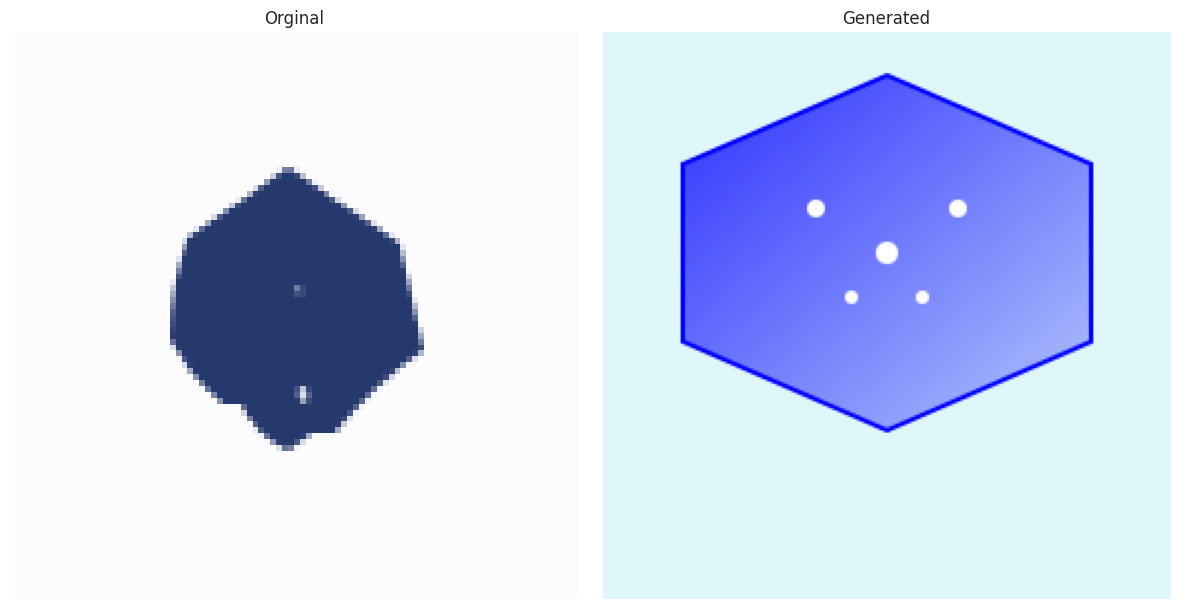

Sharp mountain silhouettes stand amidst a gradient violet to amber sky.


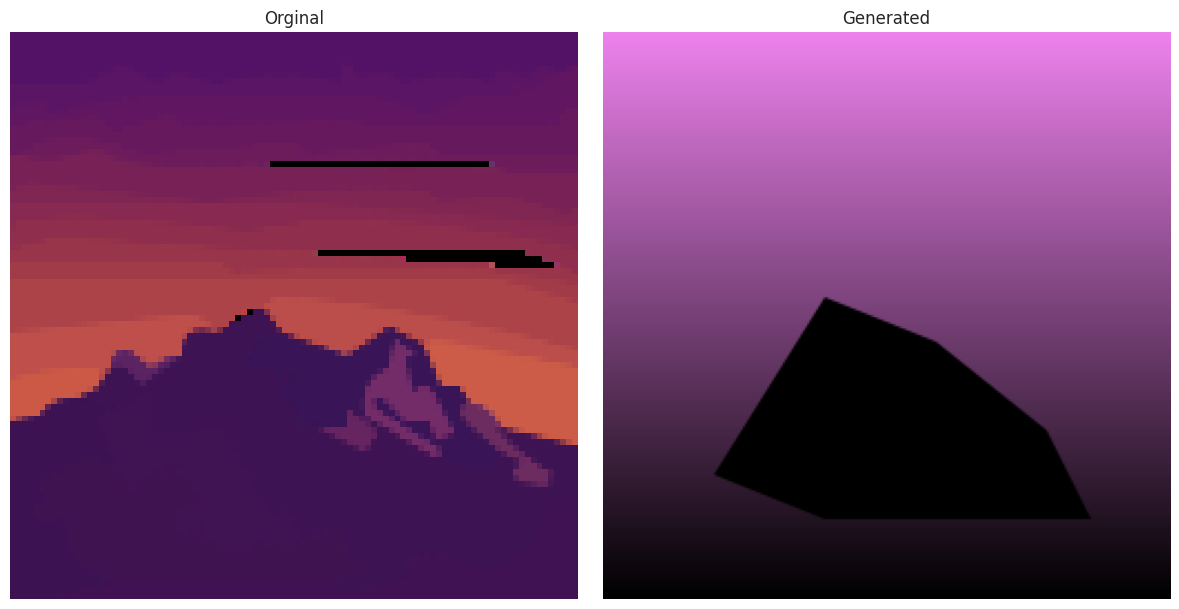

A tree composed of interlocking hexagons stands amidst drifting mist.


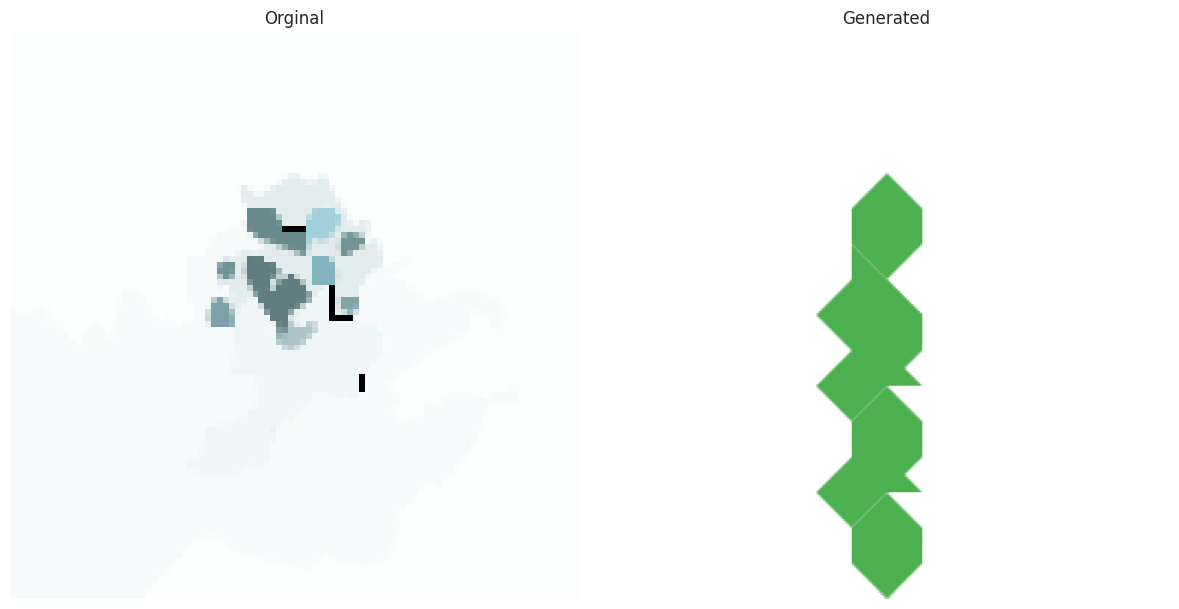

Lavender desert stretching endlessly under moonlight.


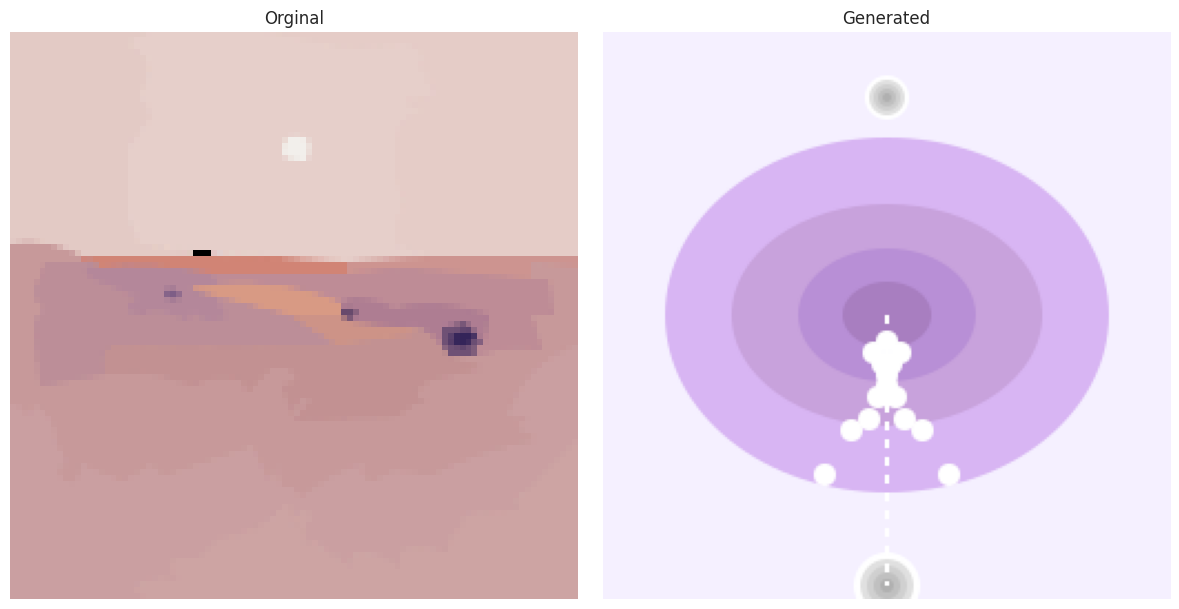

A gradient amber, peach, and cobalt sky over ebony mountains.


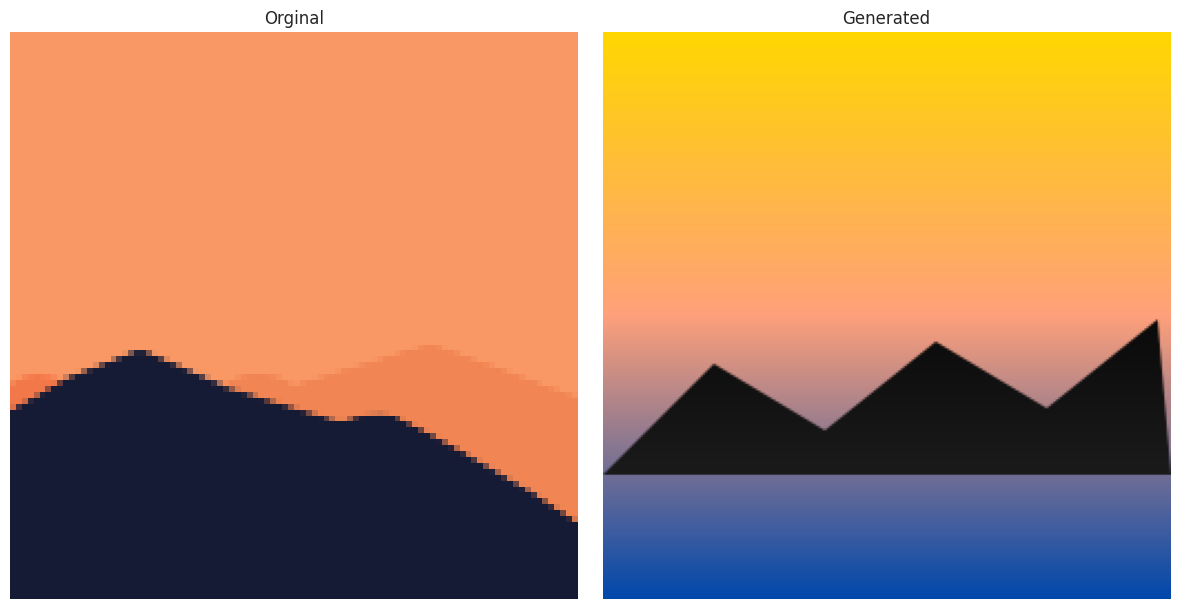

Amber canyon layers under a gradient sky with black tree silhouettes.


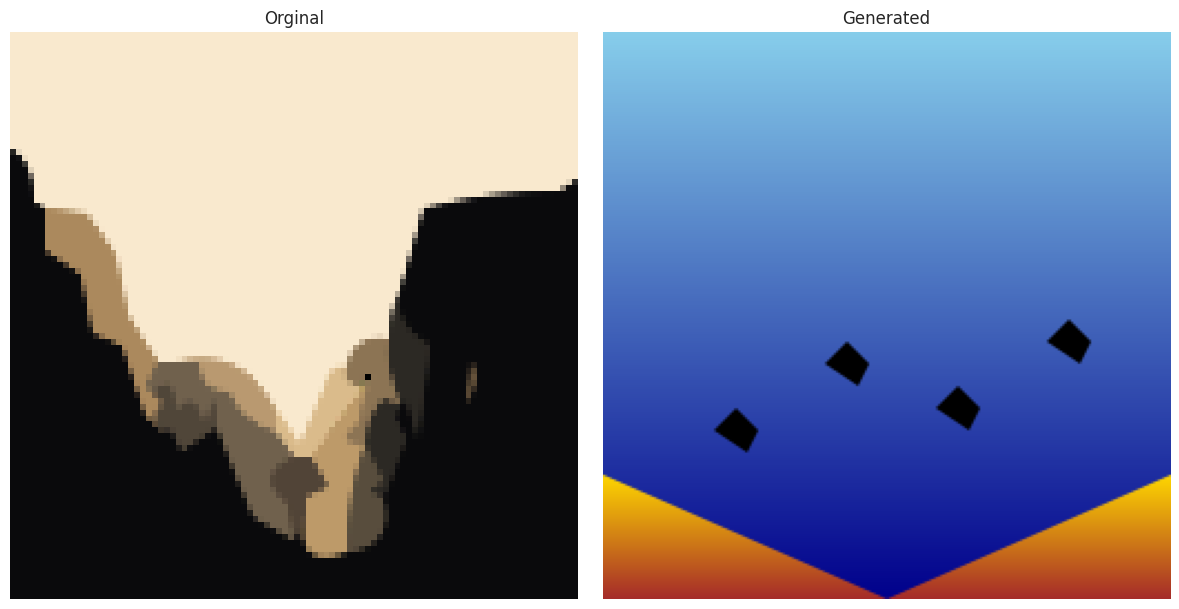

Emerald pebbles lining a winding forest path.


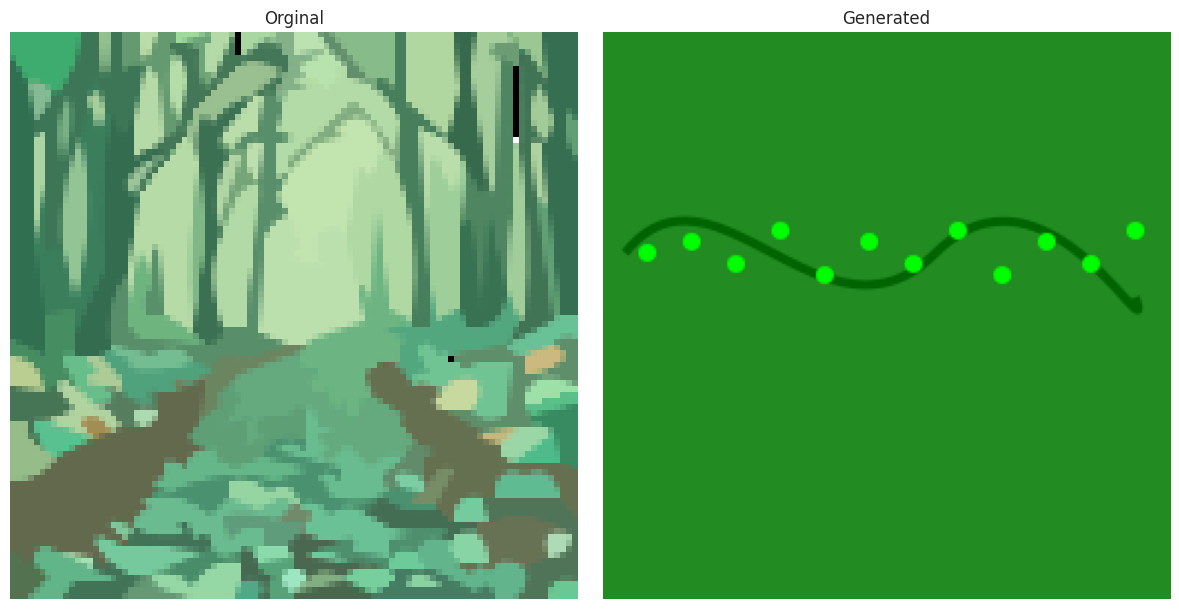

A spiral galaxy glows within a circular mandala of stars.


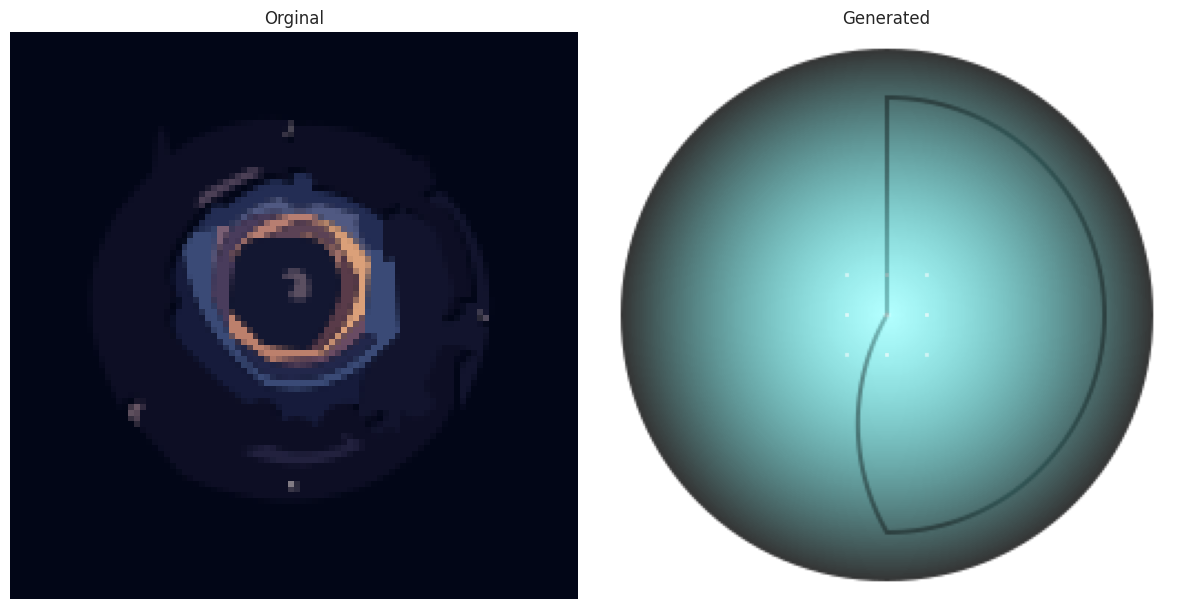

A spiral of crystalline shards reflecting shimmering light.


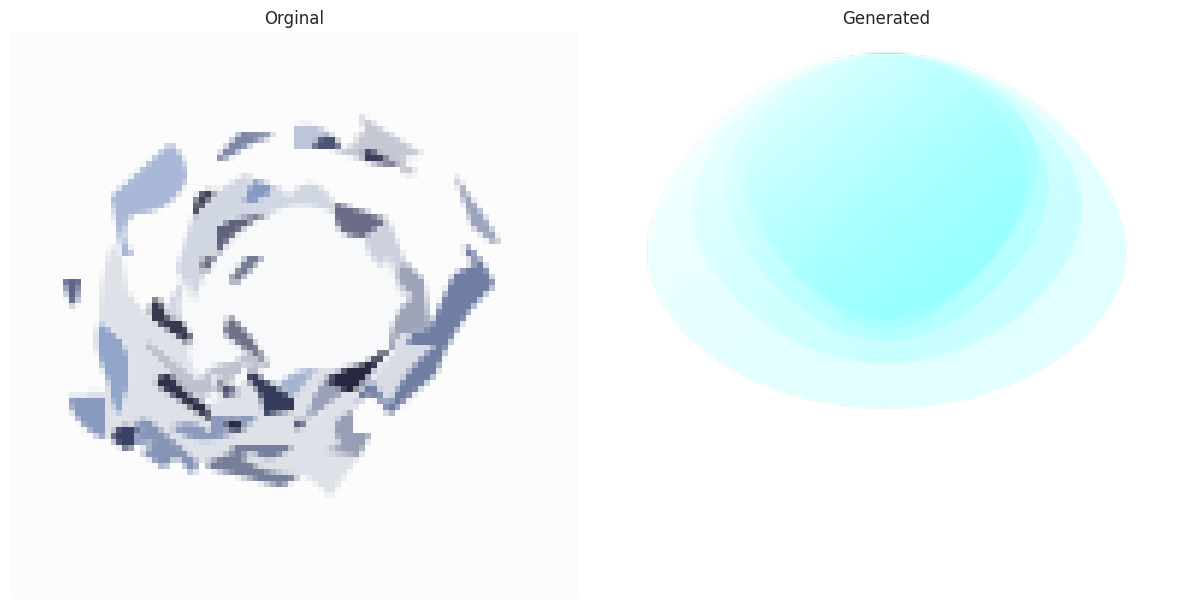

Terra cotta hexagons weave through cracked amber earth.


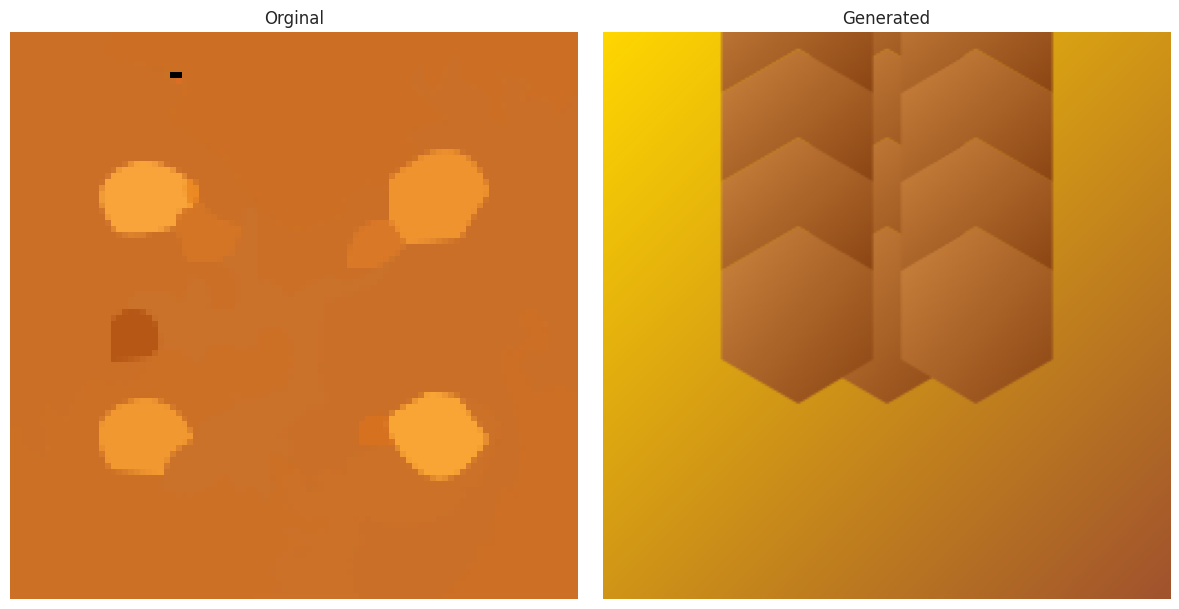

A sunset casting golden hues across a serene mountain lake.


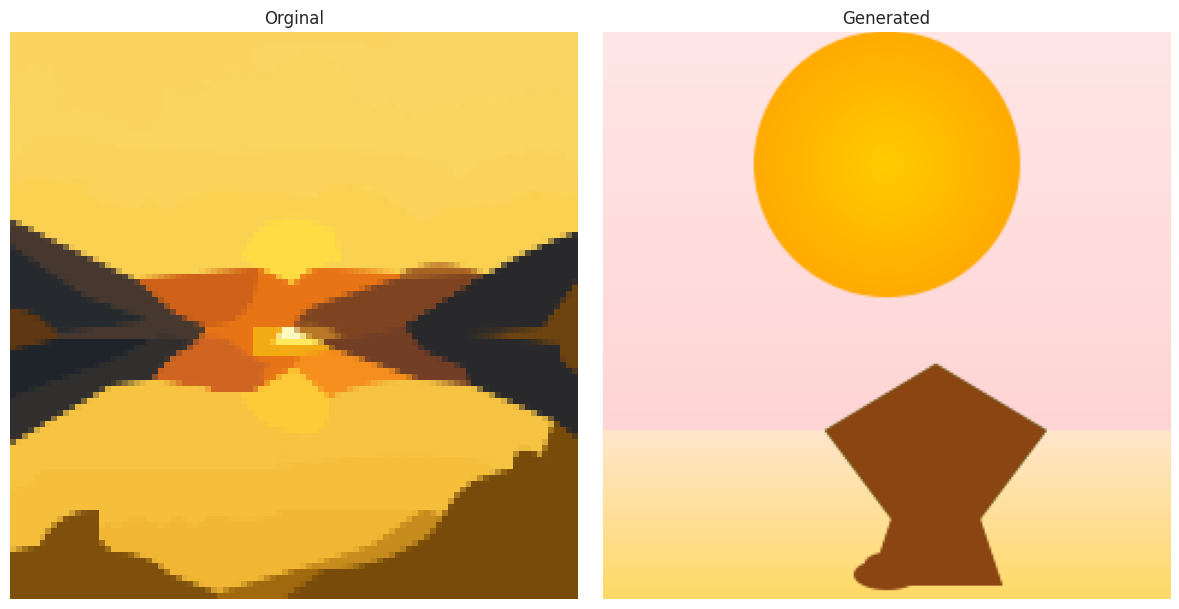

Sunlight filters through the attic, revealing a faded velvet trunk.


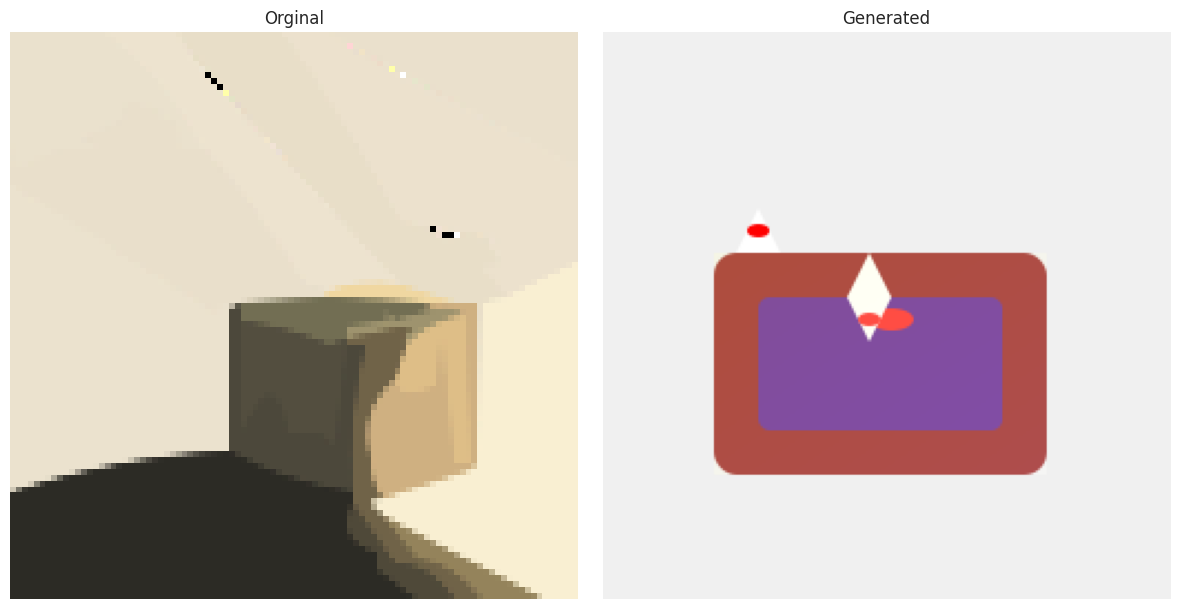

A luminous spiral galaxy centered within an intricate circular mosaic.


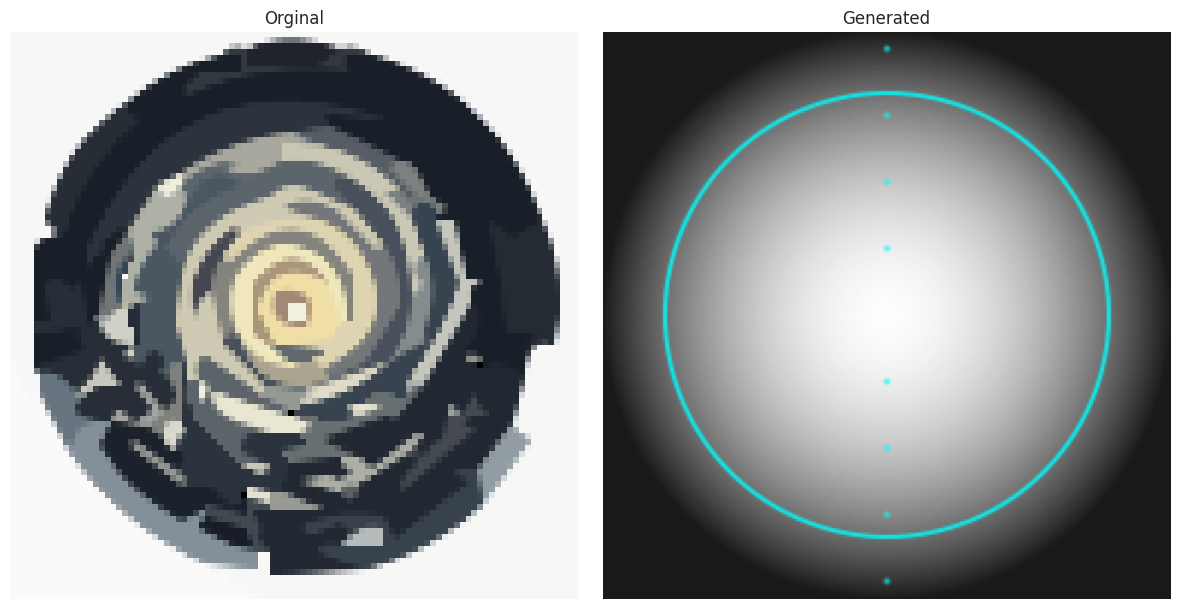

Cracked earth unites with a geometric grid in seamless pattern.


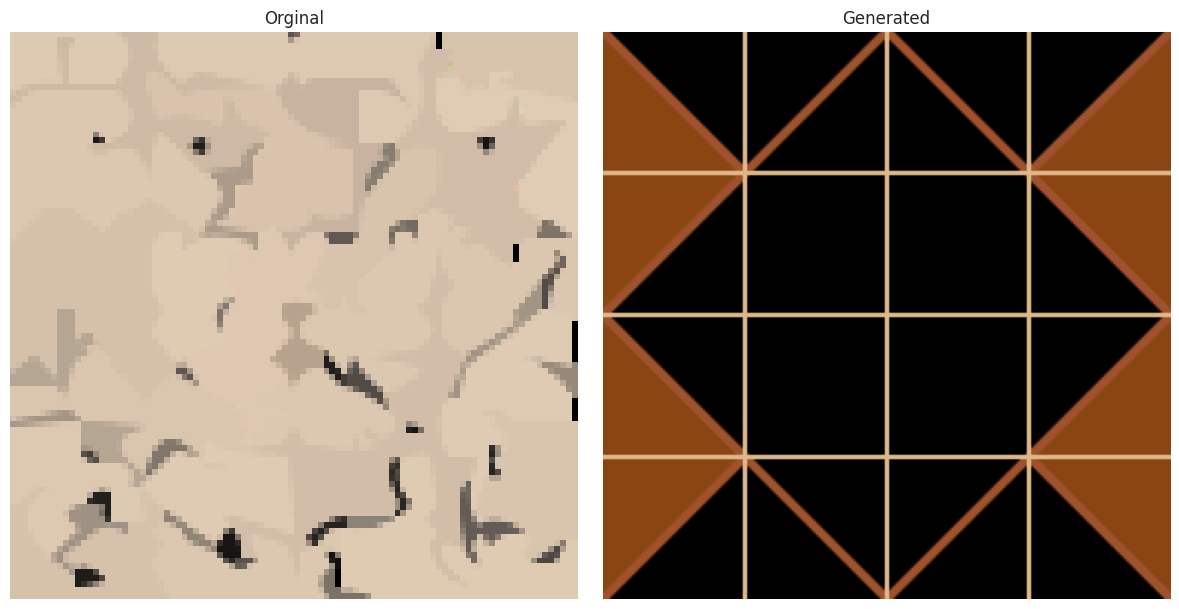

Soft morning light dances across the velvet-draped window folds.


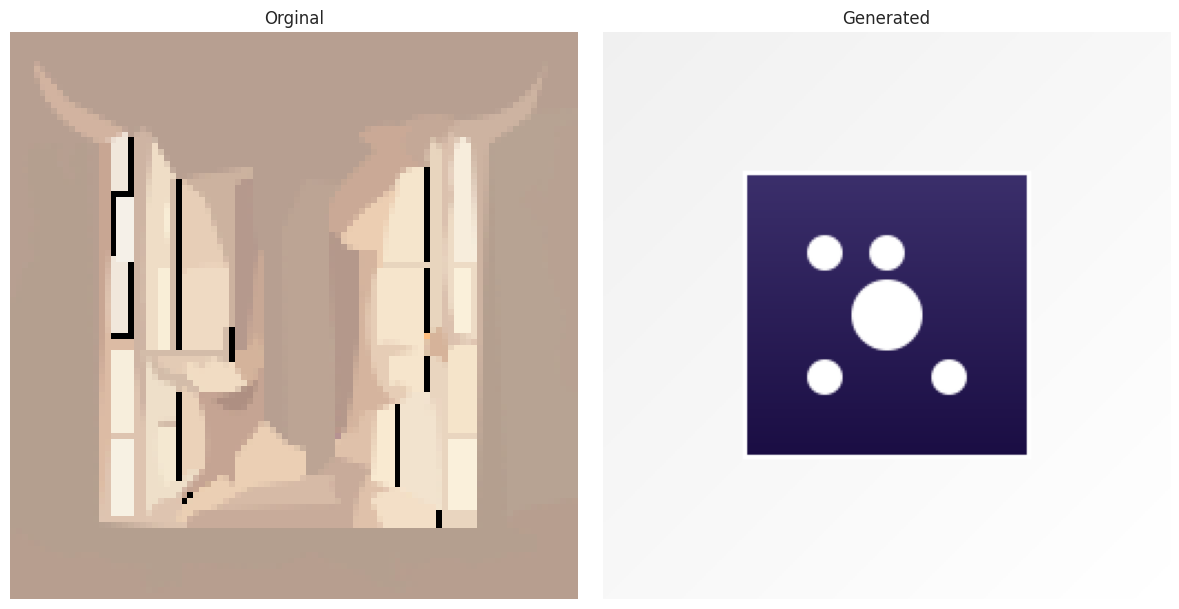

sapphire hexagons orbiting a golden cube


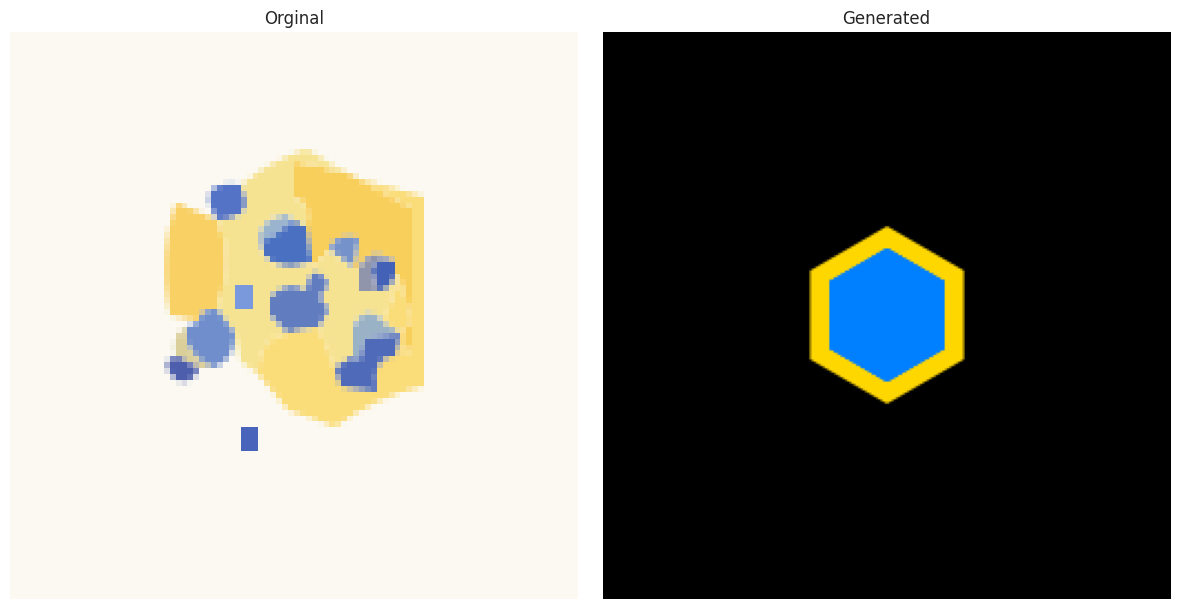

Cracked earth forms a natural checkerboard against the dry horizon.


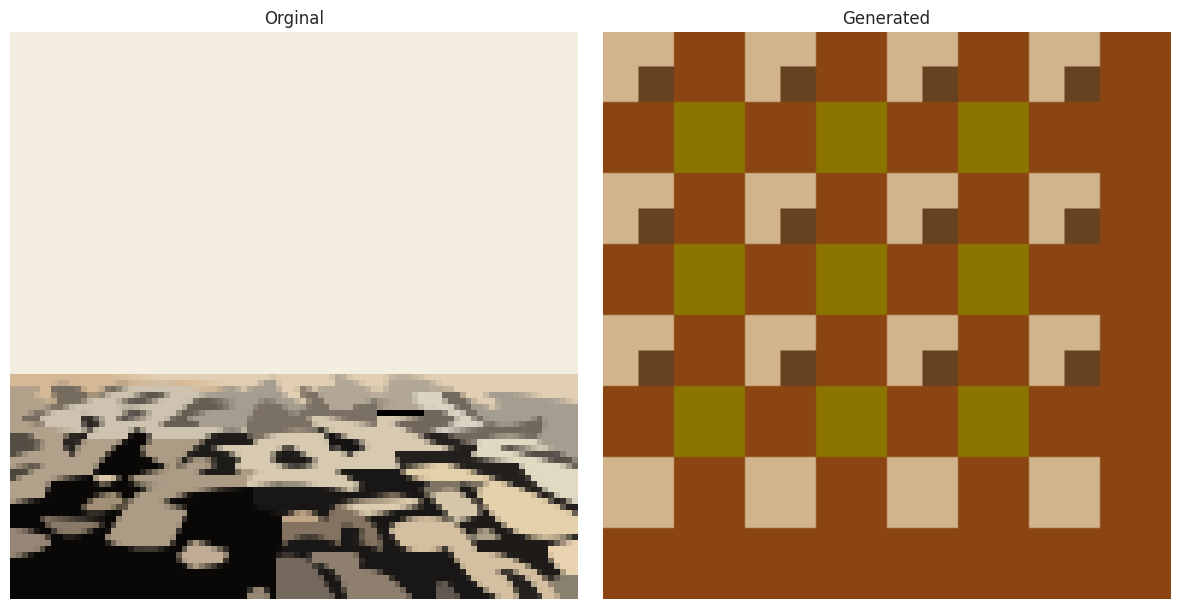

a sapphire hexagon suspended in shimmering silver mist


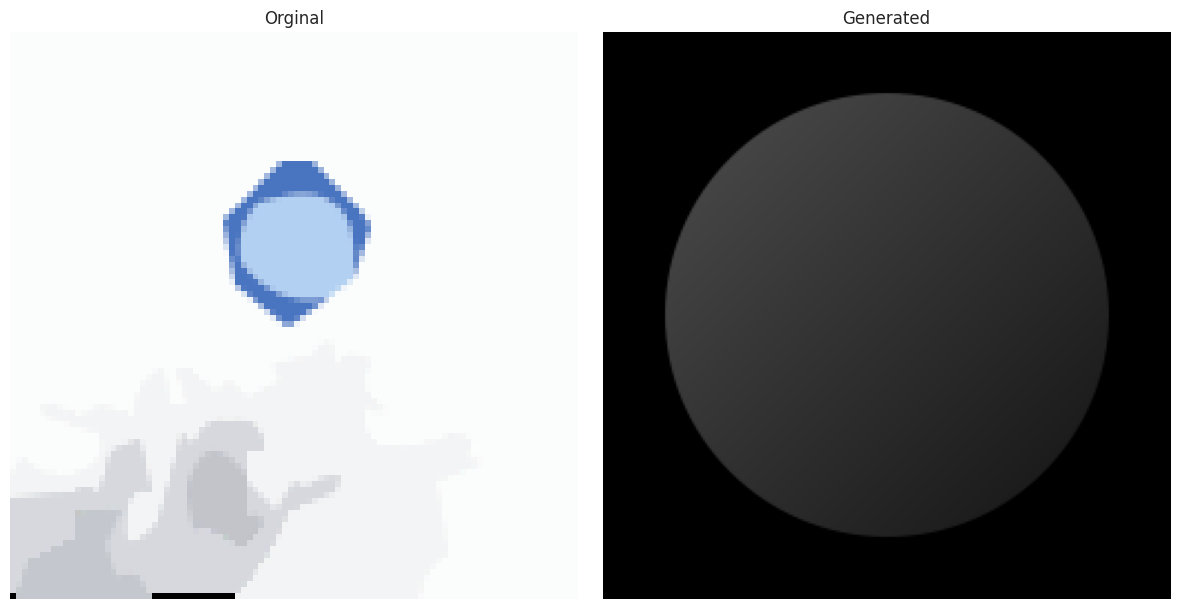

Smooth pebbles line the edge of a quiet pond.


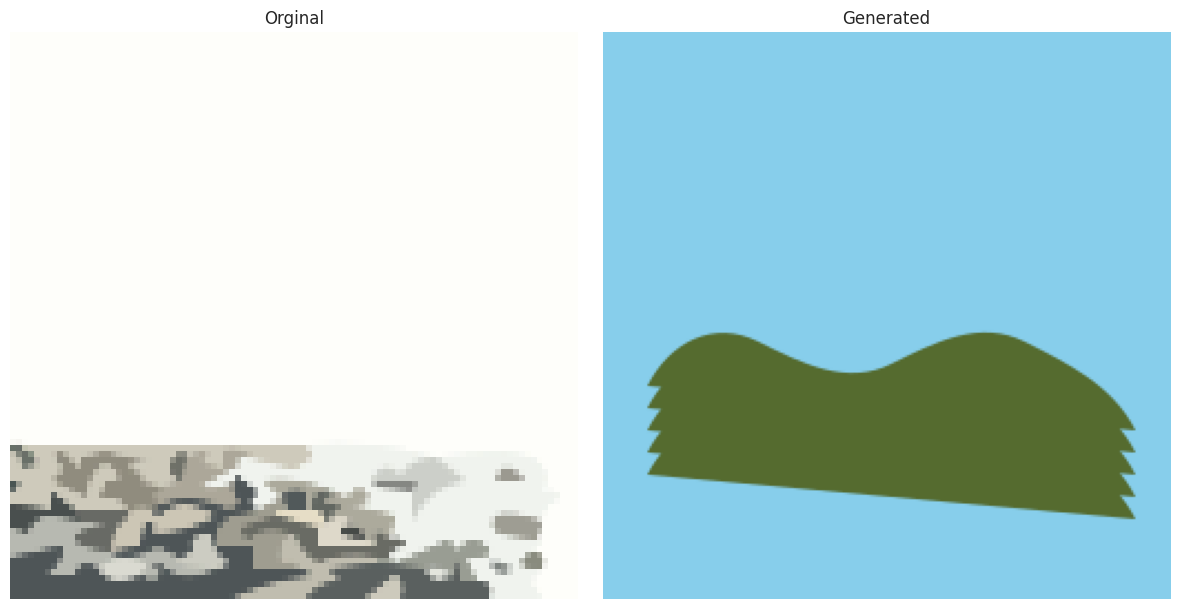

Cracked earth: dark squares etched with a geometric grid.


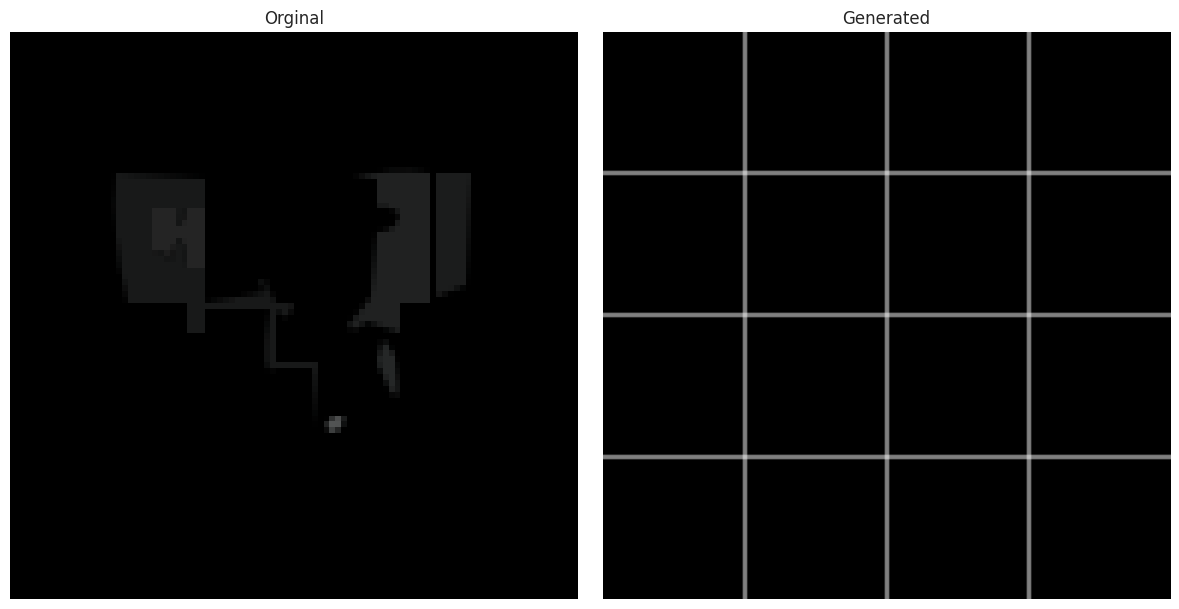

A hexagon of light glows on dark corridorâ€™s metallic walls.


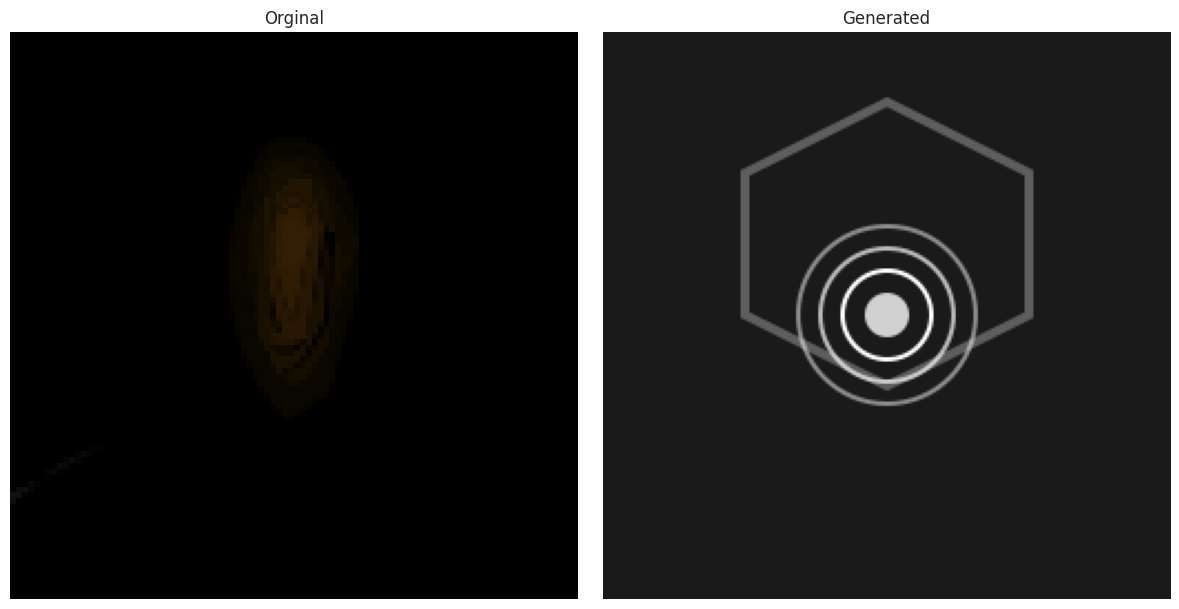

A spiral galaxy encased in a circular mosaic of sapphires.


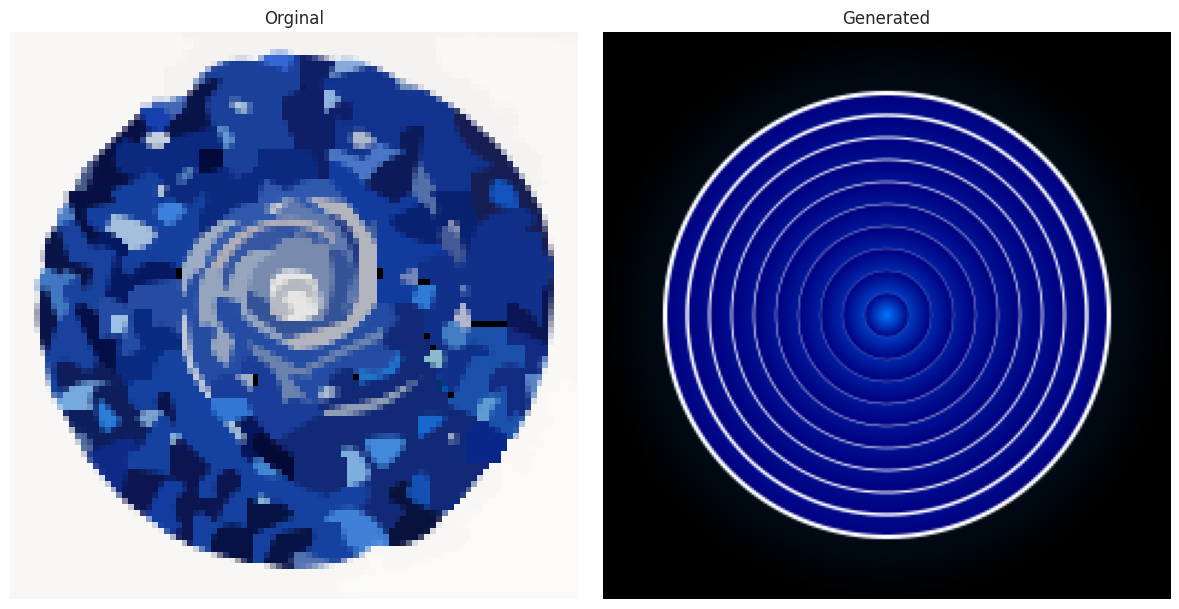

A delicate silver necklace draped across a mossy stone.


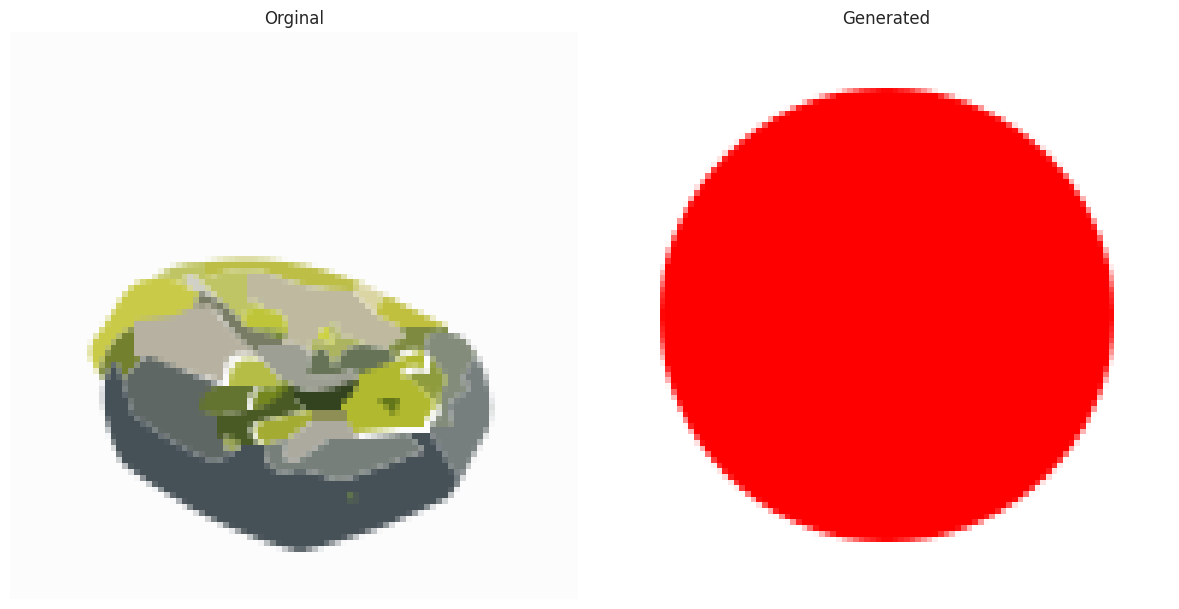

Hexagons float, interlocking on the mirror-like lake surface.


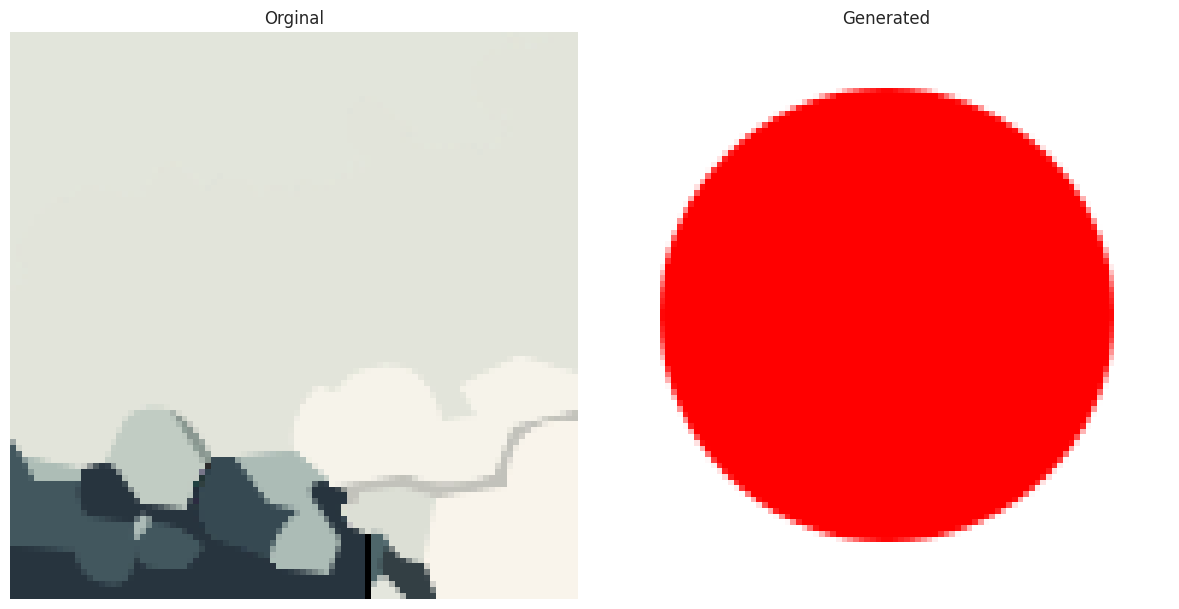

A crystal-clear river flows over glossy black stones.


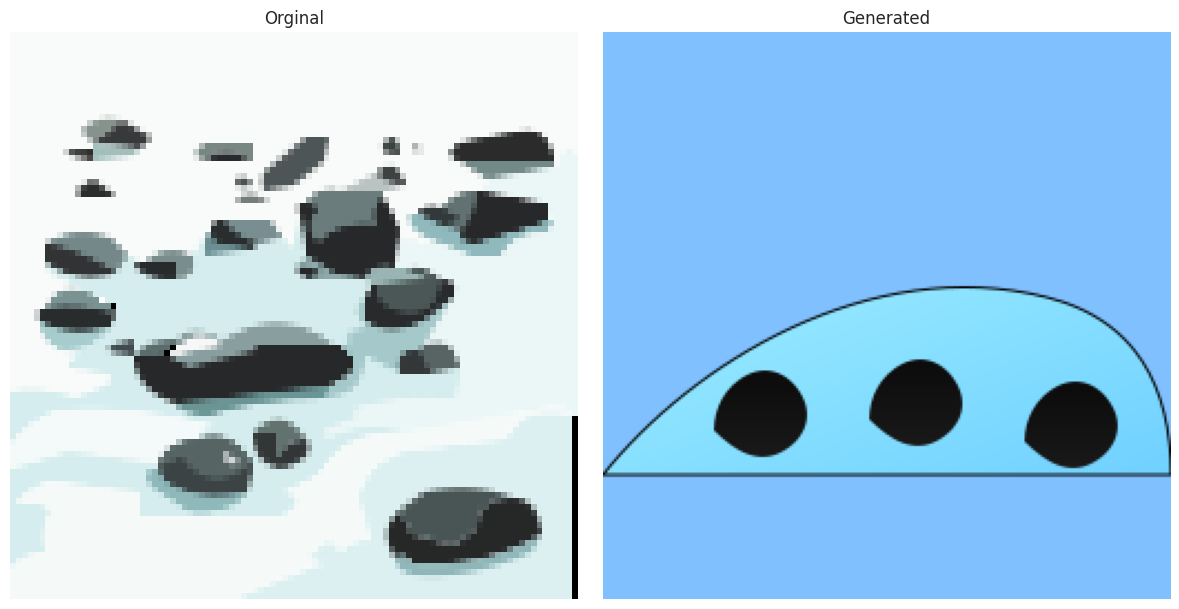

A crystalline waterfall cascades down a triangular mountain.


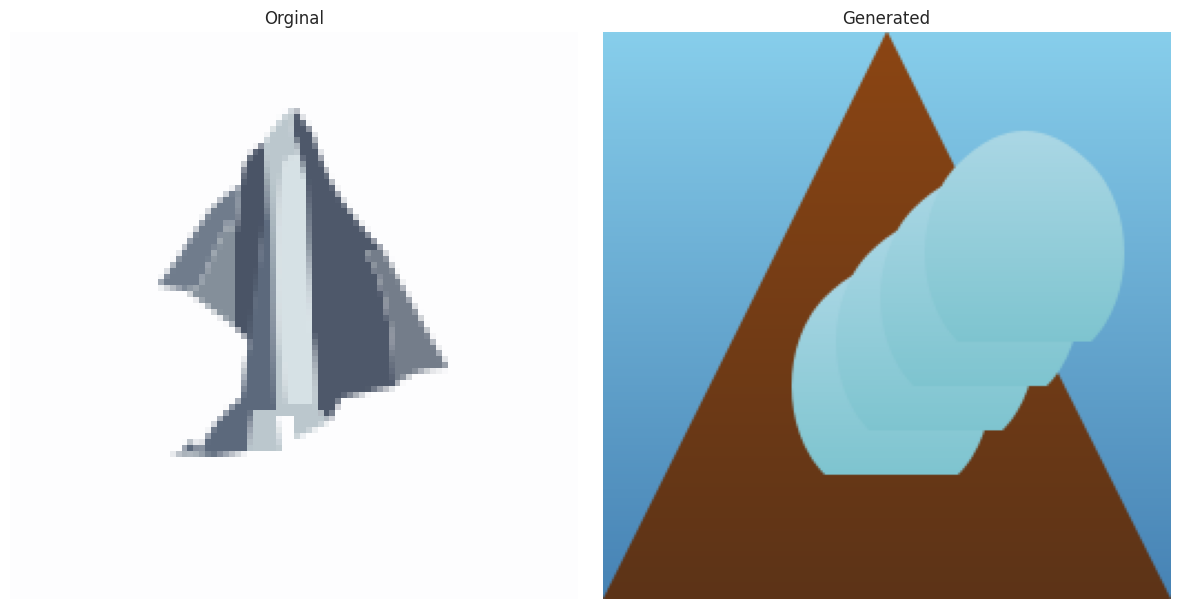

A towering tree with hexagonal, honey-gold leaves shimmering in sunlight.


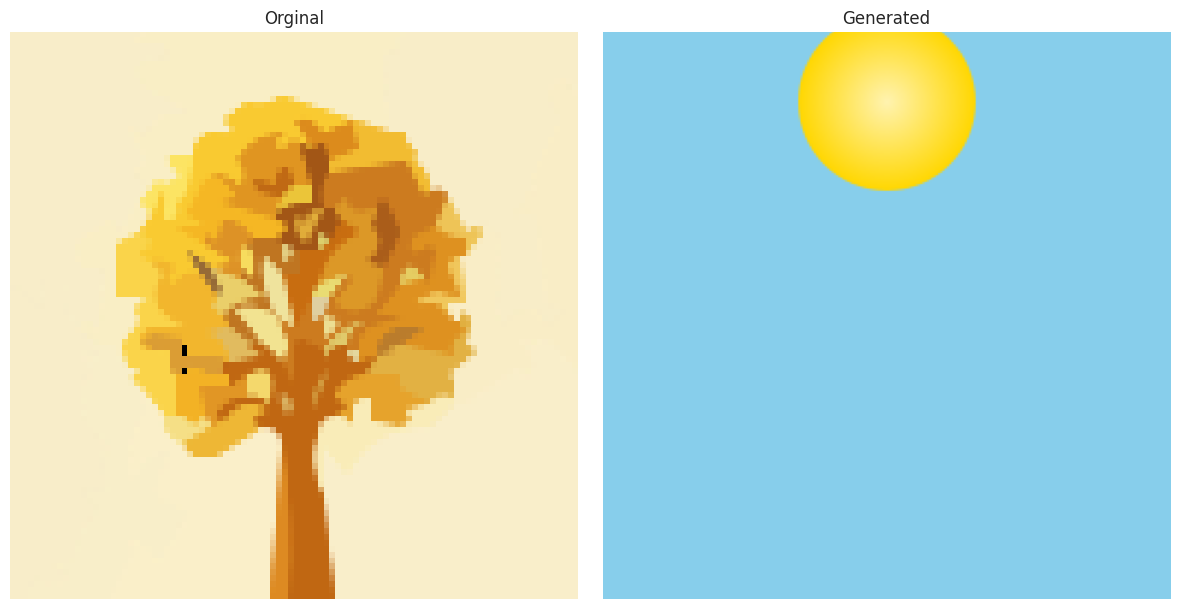

Cracked earth forms a geometric grid under the sun.


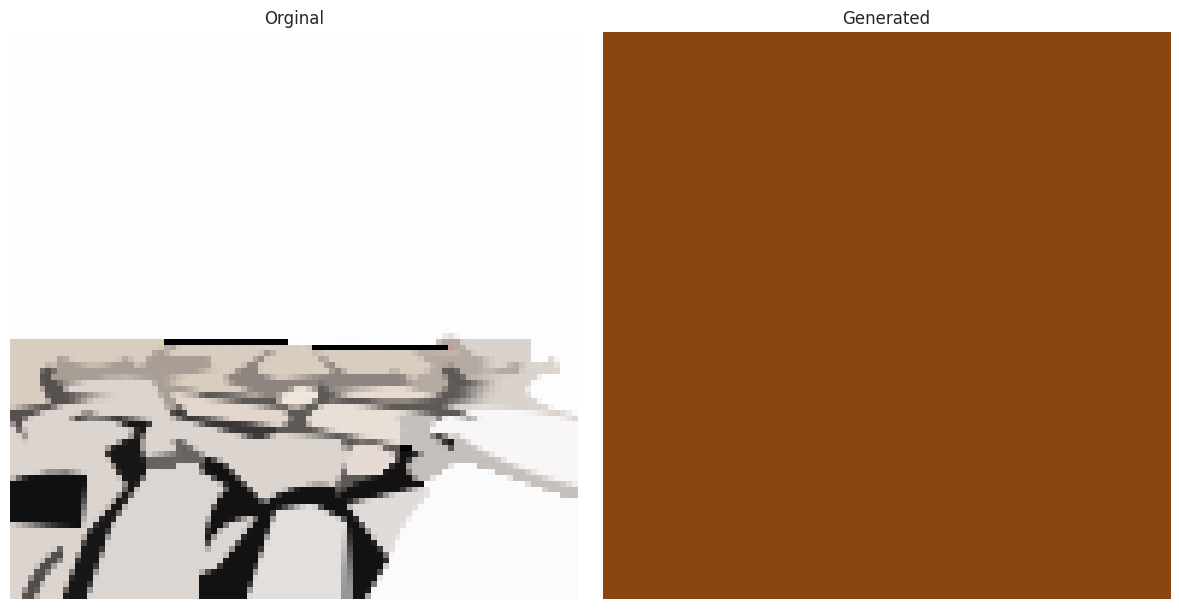

A spiral galaxy glows within a circular stained glass frame.


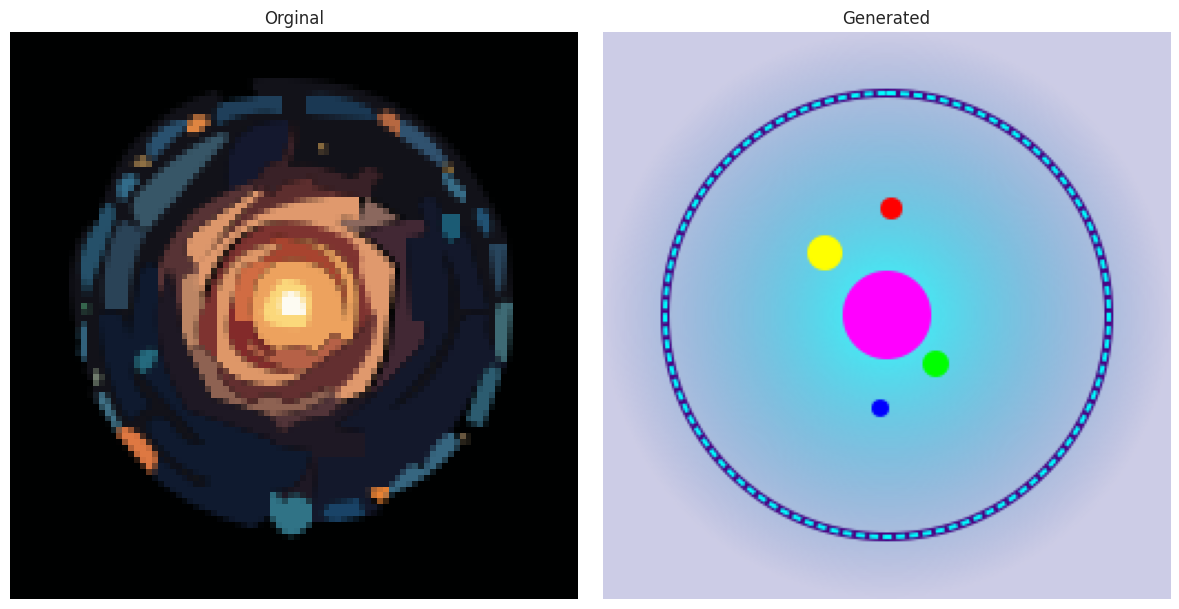

A coral and amethyst gradient sky with tall evergreen silhouettes.


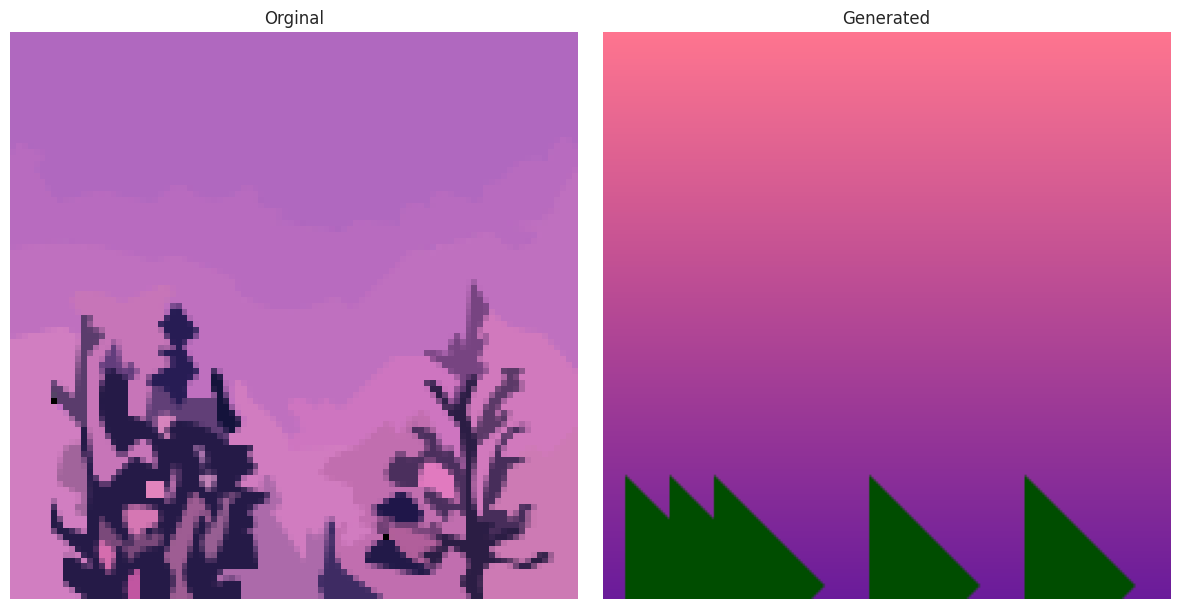

Warm orange and pink gradient sky with silhouetted pine trees.


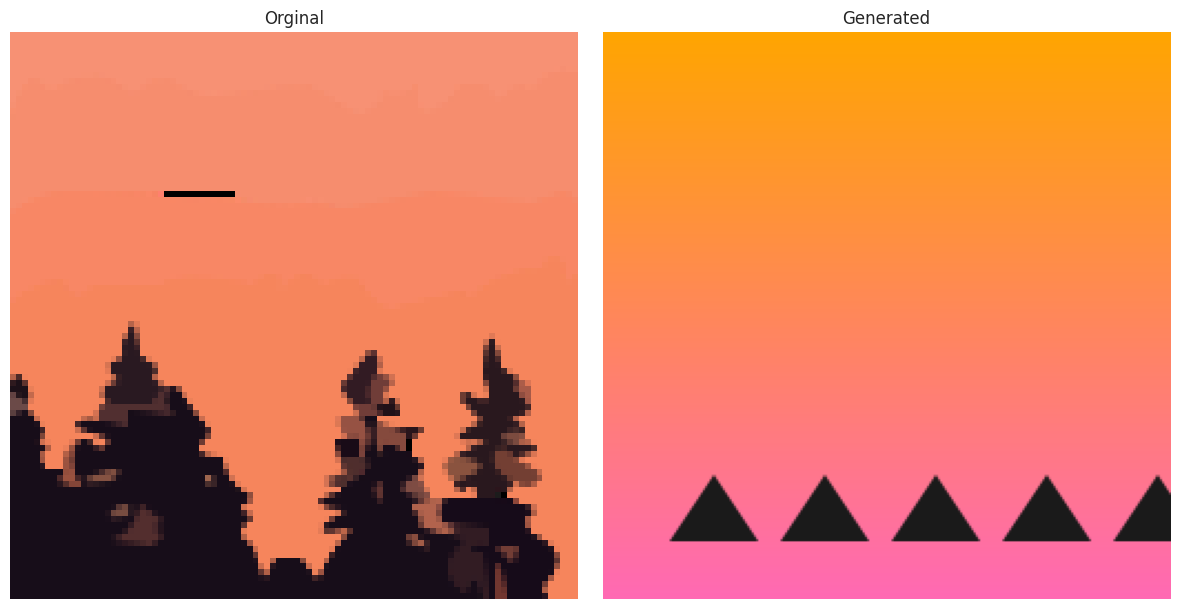

Snow-capped peaks shimmer under the golden morning sunlight.


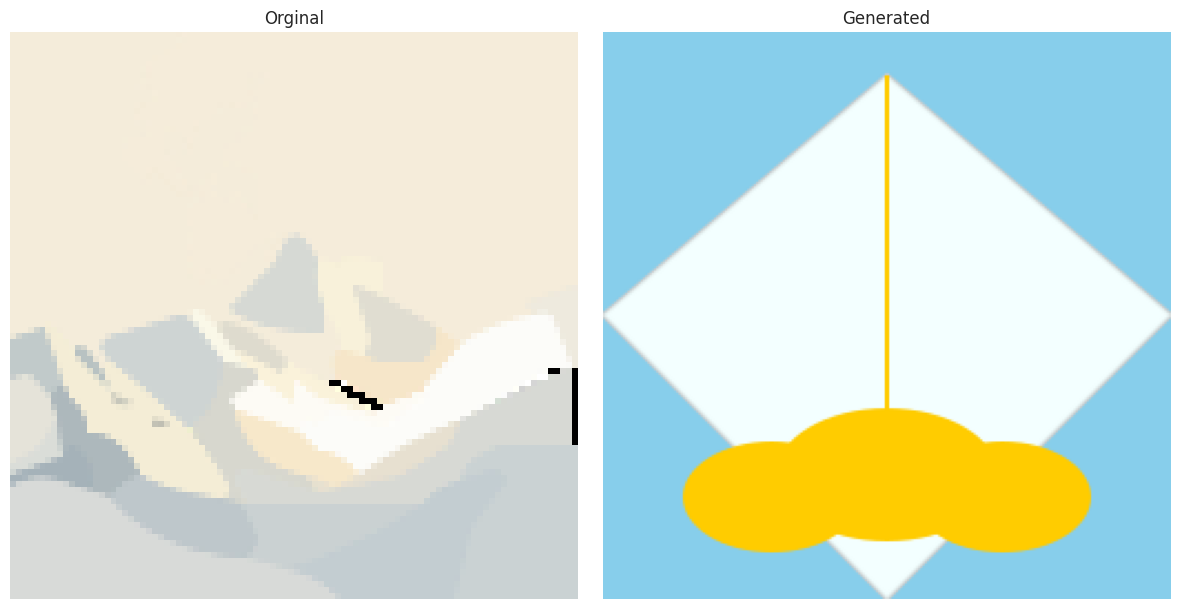

In [21]:
for_path_columns = []
num_processes = 32
for i in range(0,32,num_processes):
    start_i = i
    end_i = i+ num_processes
    batch_gereric = temp["0"][start_i:end_i].to_dict()
    generated_images_and_flags = convert_svgs_to_pngs_parallel_in_memory(list(batch_gereric.values(),), num_processes)
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    original_images = load_images_parallel(batch, num_processes)
    for i in range(len(batch)):
        print(eval_dataset.loc[start_i +i]['sentence'])
        orig_image = original_images[i]
        generated_image, flag = generated_images_and_flags[i]
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(orig_image)
        axes[0].set_title("Orginal")
        axes[0].axis("off")
        
        axes[1].imshow(generated_image)
        axes[1].set_title("Generated")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

### Оценка эстетичности в метриках

In [22]:
MLP_name = "AScore/sac+logos+ava1-l14-linearMSE.pth"
full_path = os.path.join(cur_path, MLP_name)
score_predictor = asp.AScorePredictor(full_path)
for_generated_score_column = []
for_cancel_flag=column = []
num_processes = 32
for i in tqdm(range(0, len(temp), num_processes),
              total=len(range(0, len(temp), num_processes)),
              desc="Processing batches"):
    start_i = i
    end_i = i + num_processes
    batch_gereric = temp["0"][start_i:end_i].to_dict()
    generated_images_and_flags = convert_svgs_to_pngs_parallel_in_memory(list(batch_gereric.values()), num_processes)
    images = list(map(lambda t: t[0], generated_images_and_flags))
    flags = list(map(lambda t: t[1], generated_images_and_flags))
    batch_scores = score_predictor.get_score(images).detach().cpu().numpy()
    for_generated_score_column.append(batch_scores)
    for_cancel_flag+=flags


Processing batches:   0%|          | 0/350 [00:00<?, ?it/s]

Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 проце

In [23]:
eval_results_path = os.path.join(dir_path_for_res,"eval_results.csv")

In [24]:
len(for_generated_score_column)
res = np.vstack(for_generated_score_column)
len(res)
eval_dataset["generic_AScore"] = res
eval_dataset["cancel_flag"] = for_cancel_flag
eval_dataset.to_csv(eval_results_path, index=False)
eval_dataset.head(5)
print(eval_results_path)

/home/student/kuzin/python_project/TextToSvg_MLCUP/data/Qwen/Qwen3-14B/eval_results.csv


In [25]:
eval_dataset = pd.read_csv(eval_results_path)

#### Анализ метрики эстетичности по отношению к оригиналу, процент отказов, распределение

<Axes: xlabel='original_AScore', ylabel='Count'>

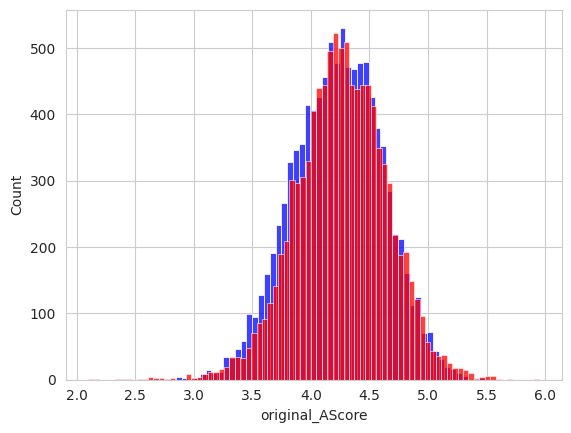

In [26]:
sns.histplot(eval_dataset[eval_dataset.cancel_flag ==2].original_AScore, color='b')
sns.histplot(eval_dataset[eval_dataset.cancel_flag ==2].generic_AScore, color='r')

#### Расчёт статистик

In [27]:
total = len(eval_dataset)

grouped_stats = eval_dataset.groupby('cancel_flag').agg(
    count=('cancel_flag', 'count'),
    percentage=('cancel_flag', lambda x: len(x)/total*100),
    mean_generic_AScore=('generic_AScore', np.mean),
    mean_original_AScore=('original_AScore', np.mean),
    score_growth=('generic_AScore', lambda x: np.mean(x - eval_dataset.loc[x.index, 'original_AScore'])),
    std_generic_AScore=('generic_AScore', np.std),
    min_generic_AScore=('generic_AScore', np.min),
    max_generic_AScore=('generic_AScore', np.max),
    median_generic_AScore=('generic_AScore', np.median)
).reset_index()

# Переименуем значения cancel_flag для понятности
grouped_stats['flag_description'] = grouped_stats['cancel_flag'].map({
    0: 'wrong_generation',
    1: 'cut_generation',
    2: 'clear_generation'
})

# Добавим общую статистику
total_row = pd.DataFrame({
    'cancel_flag': ['all'],
    'count': [total],
    'percentage': [100],
    'mean_generic_AScore': [eval_dataset['generic_AScore'].mean()],
    'mean_original_AScore': [eval_dataset['original_AScore'].mean()],
    'score_growth': [eval_dataset['generic_AScore'].mean() - eval_dataset['original_AScore'].mean()],
    'std_generic_AScore': [eval_dataset['generic_AScore'].std()],
    'min_generic_AScore': [eval_dataset['generic_AScore'].min()],
    'max_generic_AScore': [eval_dataset['generic_AScore'].max()],
    'median_generic_AScore': [eval_dataset['generic_AScore'].median()],
    'flag_description': ['all_records']
})

# Объединяем с основной таблицей
final_stats = pd.concat([grouped_stats, total_row], ignore_index=True)

/tmp/ipykernel_2768595/2244725774.py:3: FutureWarning: The provided callable <function mean at 0x78a09c3efc70> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_stats = eval_dataset.groupby('cancel_flag').agg(
/tmp/ipykernel_2768595/2244725774.py:3: FutureWarning: The provided callable <function std at 0x78a09c3efd90> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped_stats = eval_dataset.groupby('cancel_flag').agg(
/tmp/ipykernel_2768595/2244725774.py:3: FutureWarning: The provided callable <function min at 0x78a09c3ef490> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  grouped_stats = eval_dataset.groupby(

In [28]:
final_stats

,cancel_flag,count,percentage,mean_generic_AScore,mean_original_AScore,score_growth,std_generic_AScore,min_generic_AScore,max_generic_AScore,median_generic_AScore,flag_description
0,1,1073,9.606088,4.525093,4.268043,0.257050,0.000046,4.523592,4.525094,4.525094,cut_generation
1,2,10097,90.393912,4.263120,4.225431,0.037689,0.387019,2.098858,5.948924,4.264863,clear_generation
2,all,11170,100.000000,4.288285,4.229524,0.058761,0.375971,2.098858,5.948924,4.314725,all_records


In [29]:
final_stats.to_json(os.path.join(dir_path_for_res, "ascore_metrics.json"))

In [ ]:
assert 1==2

In [9]:
l = len(eval_dataset)
percent_clear_gen  = len(eval_dataset[eval_dataset.cancel_flag ==2])/l
percent_cut_gen  = len(eval_dataset[eval_dataset.cancel_flag ==1])/l
percent_wrong_gen  = len(eval_dataset[eval_dataset.cancel_flag ==0])/l
scores_gen = eval_dataset[eval_dataset.cancel_flag ==2].generic_AScore
scores_orig = eval_dataset[eval_dataset.cancel_flag ==2].original_AScore
avg_AScore = np.mean(scores_gen)
growth = np.mean(scores_gen- scores_orig)
print(scores_gen.describe())
print(scores_orig.describe())

count    9286.000000
mean        4.330871
std         0.383109
min         2.181735
25%         4.074710
50%         4.331631
75%         4.588232
max         5.627994
Name: generic_AScore, dtype: float64
count    9286.000000
mean        4.222757
std         0.387169
min         2.603742
25%         3.952383
50%         4.234322
75%         4.496176
max         5.460428
Name: original_AScore, dtype: float64


In [10]:
print(f"Процент чистых генераций: {percent_clear_gen:.2f}\nоборванных генераций: {percent_cut_gen:.2f}\nнеправильных генераций: {percent_wrong_gen:.2f}\navg_AScore: {avg_AScore:.2f}\nприрост среднего:{growth:.2f}"
)

Процент чистых генераций: 0.83
оборванных генераций: 0.17
неправильных генераций: 0.00
avg_AScore: 4.33
прирост среднего:0.11


In [11]:
assert 1==2

AssertionError: 

In [12]:
#Заполнить конфиг! Всё, что считаем нужным
model_config = {'max_new_tokens': 1500, "thinking_mode": False, "RAG_used": False}

In [13]:
exp1 = Experiment(model_name, avg_AScore=avg_AScore, growth=growth,percent_clear_gen=percent_clear_gen,percent_cut_gen=percent_cut_gen, percent_wrong_gen=percent_wrong_gen, model_config=model_config)

In [14]:
model_name = "Qwen3-8B"

In [15]:
config_path = os.path.join(cur_path, "data","@".join([model_name]+[f"{k}-{v}" for k,v in model_config.items()]))+".json"
print(config_path)
exp1.save(config_path)

/home/student/kuzin/python_project/TextToSvg_MLCUP/data/Qwen3-8B@max_new_tokens-1500@thinking_mode-False@RAG_used-False.json
